# Two Sigma Connect: Rental Listing Inquiries (kaggle)
[How much interest will a new rental listing on RentHop receive?][1]

[1]:https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries

#### TODO LIST
1. Spot-check algorithms
    - binarize target variable
    - MinMaxScaler for 'bathrooms', 'bedrooms', 'price'
2. Feature Engineerings
    - Deal with duplicate posts
        - Create flags for different levels of duplication
        - Will affect aggregate transformations among other things
    - Impute missing buildings
    - Make same buildings have same coordinates
 
3. Algorithms
    - A Python Automated Machine Learning tool that optimizes machine learning pipelines using genetic programming. http://rhiever.github.io/tpot/
        - http://rhiever.github.io/tpot/using/#tpot-with-code
    - pyglmnet
4. Probability calibration
    - Obtaining Calibrated Probabilities from Boosting (paper in Evernote)
        -"We also experiment with boosting using log-loss instead of the usual exponential loss. Experiments show that Logistic Correction and boosting with log-loss work well when boosting weak models such as decision stumps, but yield poor performance when boosting more complex models such as full decision trees. Platt Scaling and Isotonic Regression, however, significantly improve the probabilities predicted by both boosted stumps and boosted trees."
3. NLP
    - Description
        - binarize features, i.e. BOW
        - LDA with description
    - 


##### Setup (imports, constants, etc.)

In [1]:
from copy import deepcopy
import pdb
import warnings
from imp import reload
import time
from pprint import pprint
import random
from copy import deepcopy
import pickle

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import (StratifiedShuffleSplit, train_test_split,
                                     validation_curve)
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.feature_selection import (SelectKBest, chi2, mutual_info_classif,
                                       f_classif)
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, log_loss, make_scorer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import (LabelBinarizer, LabelEncoder,
                                   MinMaxScaler, StandardScaler,
                                   OneHotEncoder, Imputer)
from sklearn.ensemble import (GradientBoostingClassifier,
                              RandomForestClassifier)
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from scipy import stats
from IPython.display import display
from sklearn_pandas import DataFrameMapper
import xgboost as xgb
from xgboost import XGBClassifier
from pyglmnet import GLM
from sklearn.utils.validation import check_is_fitted

import pdir

from outlier_detection import *
from preprocessing import (LogTransformer, SqrtTransformer, BedBathImputer,
                           LatLongImputer, LenExtractor, GroupSumExtractor,
                           WordCntExtractor, DayBinarizer, ItemSelector,
                           feature_prep)
from eda_plots import *
from validation_plots import *
from main import *

%matplotlib inline

%load_ext autoreload
%autoreload 2

pd.set_option('display.float_format', lambda x: '%.5f' % x)

SEED = 42
np.random.seed(SEED)

DAT_DIR = '../Data/'
SUBM_DIR = '../Submissions/'
TEST_DIR = '../Tests/'
REPORT_IMG_DIR = '../Report-Images/'

TRAIN_FP = ''.join([DAT_DIR, 'train.json'])
TEST_FP = ''.join([DAT_DIR, 'test.json'])
SAMPLE_FP = ''.join([DAT_DIR, 'sample_submission.csv'])
DF_TRAIN_PKL = ''.join([DAT_DIR, 'df_train.pkl'])
DF_TEST_PKL = ''.join([DAT_DIR, 'df_test.pkl'])

scorer_acc = make_scorer(accuracy_score)

# using built-in 'neg_log_loss' scoring param used for simplicity
# source code show exact same make_scorer call, kept for reference
scorer = make_scorer(log_loss, greater_is_better=False,
                     needs_proba=True)

scoring = 'neg_log_loss'

df = read_rental_interest(DF_TRAIN_PKL)
df_te = read_rental_interest(DF_TEST_PKL)

/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
np.logspace

<function numpy.core.function_base.logspace>

# Exploratory Data Analysis

## Train vs test data

In [8]:
df = read_rental_interest(DF_TRAIN_PKL)
df_te = read_rental_interest(DF_TEST_PKL)

df.shape, df_te.shape

((49352, 14), (74659, 13))

### Are datasets random samples from same source?

In [3]:
# Same size for easier comparisons
df_te = df_te.sample(n=len(df), random_state=SEED)

Kolmogorov-Smirnov p-value: 0.981
Show sampled same distribution very likely


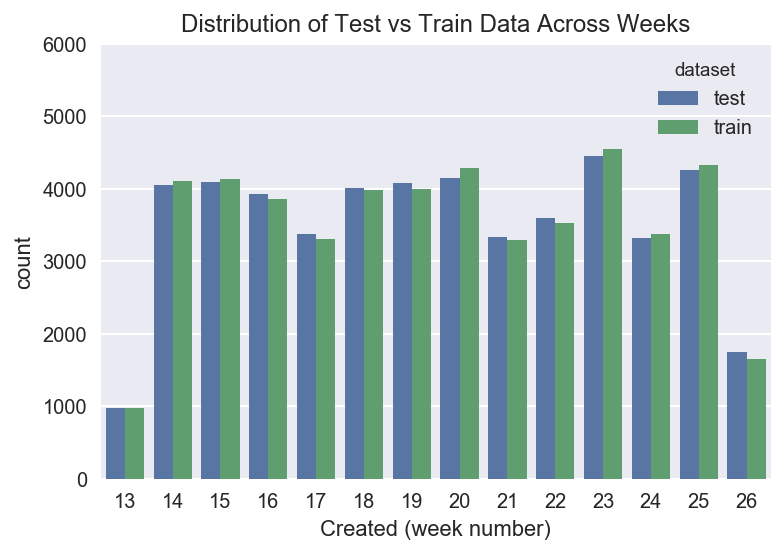

In [4]:
df_te = df_te.sample(n=len(df), random_state=SEED)
plot_count_comparison(
    x='week',
    df = df.assign(week=df.created.dt.week),
    df_te = df_te.assign(week=df_te.created.dt.week))

plt.ylim(0, 6000)
plt.xlabel('Created (week number)')
plt.title('Distribution of Test vs Train Data Across Weeks')

_, ks2_pval = stats.ks_2samp(df_te.created.dt.week, df.created.dt.week)
print('Kolmogorov-Smirnov p-value: {:.3f}'.format(ks2_pval))
print('Show sampled same distribution very likely')

plt.show()

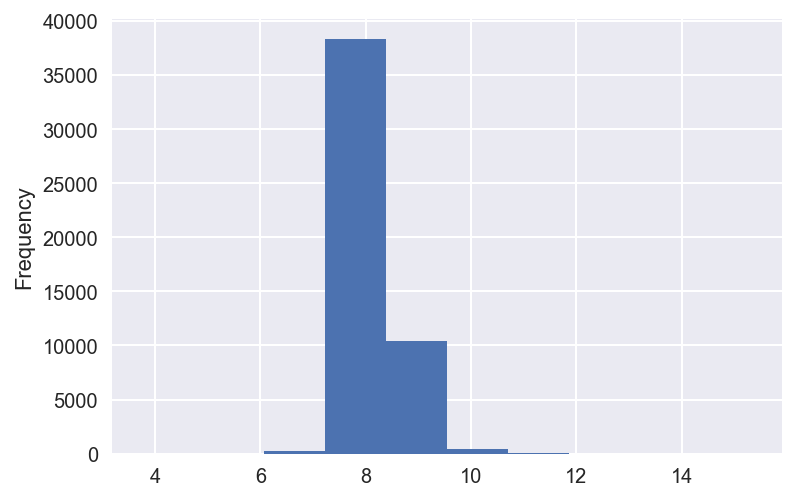

In [5]:
np.log(df.price).plot('hist')

Kolmogorov-Smirnov p-value: 0.940
Show sampled same distribution very likely


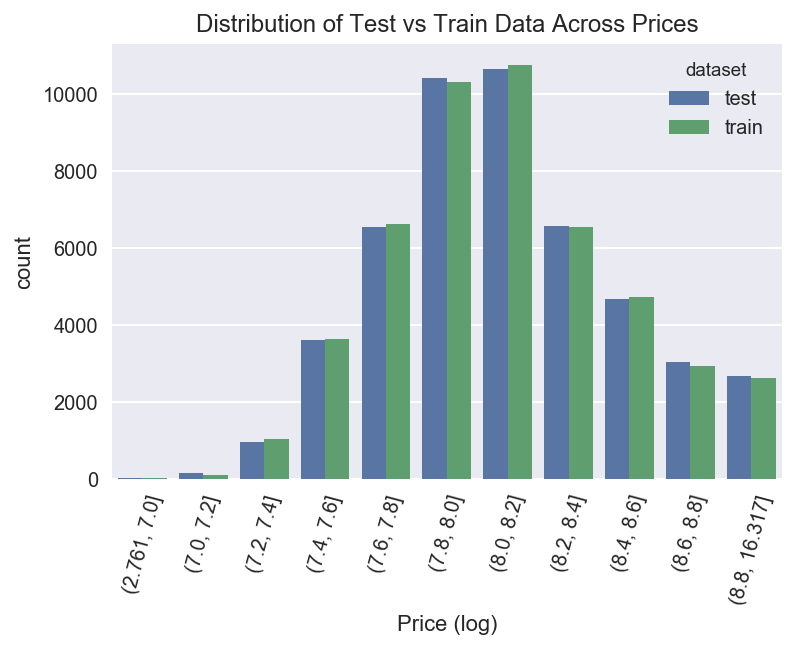

In [6]:
df_te = df_te.sample(n=len(df), random_state=SEED)

min_ = np.log(df.price.min()) - 1
max_ = np.log(df.price.max()) + 1
bins = [min_, 7, 7.2, 7.4, 7.6, 7.8, 8, 8.2, 8.4, 8.6, 8.8, max_]

data_tr = df.assign(lg_price=pd.cut(np.log(df.price), bins))
data_te = df_te.assign(lg_price=pd.cut(np.log(df_te.price), bins))

ax = plot_count_comparison(x='lg_price', df=data_tr, df_te=data_te)

plt.xticks(rotation=75)
plt.xlabel('Price (log)')
plt.title('Distribution of Test vs Train Data Across Prices')

_, ks2_pval = stats.ks_2samp(df_te.price, df.price)
print('Kolmogorov-Smirnov p-value: {:.3f}'.format(ks2_pval))
print('Show sampled same distribution very likely')

plt.show()

In [7]:
print('***Kolmogorov-Smirnov p-values***')
for name in df.drop('interest_level', axis=1).select_dtypes([int, float]).columns:
    _, ks2_pval = stats.ks_2samp(df[name], df_te[name])
    print('{:<10}: {:>5.3f}'.format(name, ks2_pval))

***Kolmogorov-Smirnov p-values***
bathrooms : 0.995
bedrooms  : 0.998
latitude  : 0.231
longitude : 0.747
price     : 0.940


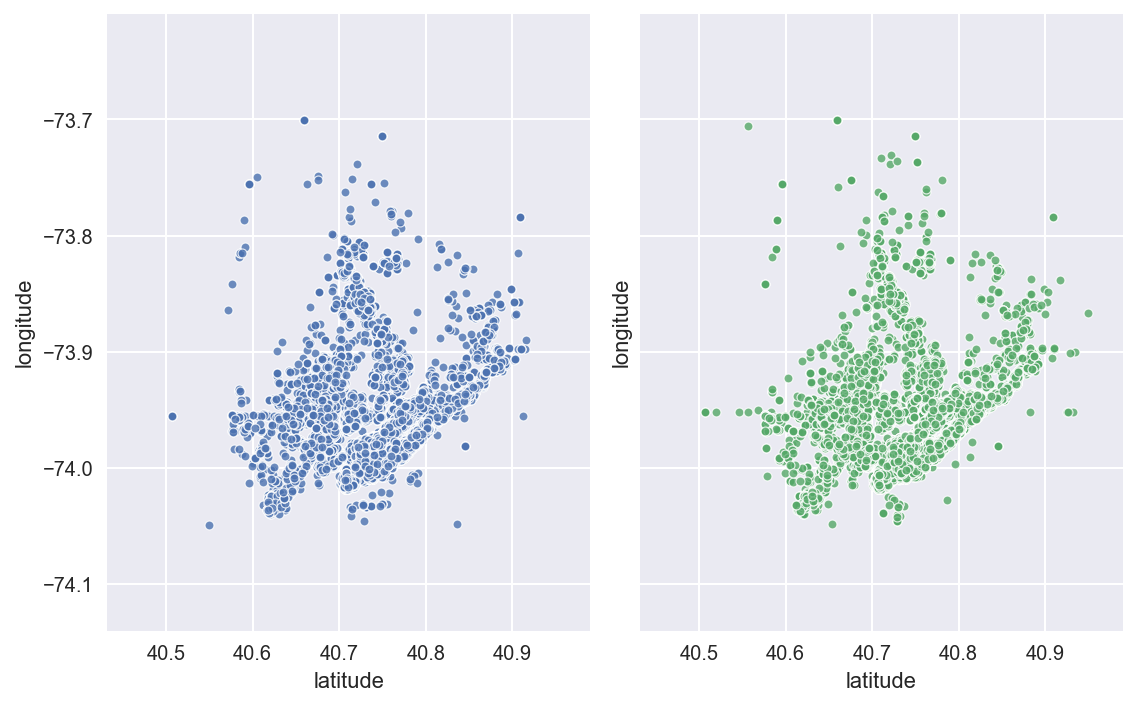

In [8]:
df1 = LatLongImputer().fit_transform(df).assign(dataset='train')
df2 = LatLongImputer().fit_transform(df_te).assign(dataset='test')

data = pd.concat([df1, df2])

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 5),
                               sharex=True, sharey=True)

with sns.axes_style('white'):
    for ax, df in ((ax1, df1), (ax2, df2)):
        sns.regplot(x='latitude', y='longitude', data=df, fit_reg=False,
                    ax=ax, scatter_kws=dict(edgecolor='w', lw=.6, s=20)
)
plt.tight_layout()

In [9]:
df = read_rental_interest(DF_TRAIN_PKL)
df_te = read_rental_interest(DF_TEST_PKL)

In [10]:
tr_cnts = df.manager_id.value_counts()
te_cnts = df_te.manager_id.value_counts()

merged = pd.concat([tr_cnts, te_cnts], axis=1)
n_diff = merged.isnull().any(1).sum()
n_in_both = len(merged)-n_diff
print('{:.0%} of managers in both datasets'.format(n_in_both/len(merged)))

tr_cnts = df.building_id.value_counts()
te_cnts = df_te.building_id.value_counts()

merged = pd.concat([tr_cnts, te_cnts], axis=1)
n_diff = merged.isnull().any(1).sum()
n_in_both = len(merged)-n_diff
print('{:.0%} of buildings in both datasets'.format(n_in_both/len(merged)))

67% of managers in both datasets
45% of buildings in both datasets


### Are there any rentals listed twice?

In [11]:
df = read_rental_interest(DF_TRAIN_PKL)
df_te = read_rental_interest(DF_TEST_PKL)

df_all = pd.concat([df.drop('interest_level', axis=1), df_te])
df_all.shape

(124011, 13)

In [12]:
subset = ['bedrooms', 'bathrooms', 'price', 'building_id', 'manager_id']
is_dupe = df.duplicated(subset, keep=False)
df[is_dupe].sort_values(subset).T

listing_id,6842689,7112955,6834172,6872105,7162560,7028603,6921691,7032828,6978996,7002150,...,7074029,7232801,6989183,6999811,7006884,7017467,6895545,7216315,7093306,7159729
bathrooms,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,5.00000,5.00000,2.00000,2.00000,2.00000,2.00000,3.00000,3.00000,4.00000,4.00000
bedrooms,0,0,0,0,0,0,0,0,0,0,...,5,5,6,6,6,6,6,6,6,6
building_id,acf04eb24372da8ce23a7f73c3b099da,acf04eb24372da8ce23a7f73c3b099da,d8b20f7bd163403c49d242d50607cc0d,d8b20f7bd163403c49d242d50607cc0d,70093585319d049535fdc64e4f387da3,70093585319d049535fdc64e4f387da3,af79d0d2ed3d31362185fed210e97cb3,af79d0d2ed3d31362185fed210e97cb3,af79d0d2ed3d31362185fed210e97cb3,af79d0d2ed3d31362185fed210e97cb3,...,4c82773ff23782a525c36ff0699cb153,4c82773ff23782a525c36ff0699cb153,216377a6c7d73665e5a15db7663b1ef4,216377a6c7d73665e5a15db7663b1ef4,0,0,216377a6c7d73665e5a15db7663b1ef4,216377a6c7d73665e5a15db7663b1ef4,c349dabcf5a949ed6817a721adb7daab,c349dabcf5a949ed6817a721adb7daab
created,2016-04-08 02:56:02,2016-06-05 02:53:45,2016-04-06 08:04:51,2016-04-14 04:09:51,2016-06-15 03:00:25,2016-05-18 02:57:34,2016-04-25 02:34:07,2016-05-18 07:22:52,2016-05-07 03:14:38,2016-05-12 05:40:54,...,2016-05-27 02:33:39,2016-06-29 06:13:27,2016-05-10 03:15:08,2016-05-12 02:43:54,2016-05-13 04:56:06,2016-05-15 05:52:33,2016-04-19 05:40:00,2016-06-25 05:28:36,2016-06-01 06:07:31,2016-06-14 15:42:54
description,Spacious studio at Sullivan Mews.Sullivan Mews...,Spacious studio at Sullivan Mews--available la...,Studio on Upper West Side,Studio on Upper West Side,"90 West Street is a beautiful pre-war, full se...","90 West Street is a beautiful pre-war, full se...","upscale apartments complemented by beautiful, ...","upscale apartments complemented by beautiful, ...","upscale apartments complemented by beautiful, ...","upscale apartments complemented by beautiful, ...",...,Magnificent 5 bedroom / 5 bathroom duplex pent...,Magnificent 5 bedroom / 5 bathroom duplex pent...,This beautiful 6 bedroom apartment is brand ne...,This beautiful 6 bedroom apartment is brand ne...,TRUE 6 bedrooms and are Queen sized and 2 Ful...,TRUE 6 bedrooms and are Queen sized and 2 Ful...,"NO FEE!!!, Fantastic for sharing, bright 6 Bed...","Bright, Perfect for Sharing 6 Bedroom / 3 Bath...","Unique and rare 6 bedroom, 4 bath apartment wi...","Unique and rare 6 bedroom, 4 bath apartment wi..."
display_address,115 Sullivan Street,115 Sullivan Street,W 87th St,W 87th St,90 West Street,90 West Street,East 82nd Street,East 82nd Street,East 82nd Street,East 82nd Street,...,East 94th Street,East 94th Street,W 107 St.,W 107 St.,311 Broadway,311 Broadway,West 107th Street,West 107th Street,E 70th St,E 70th St
features,"[No Fee, Exclusive, Elevator]","[No Fee, Exclusive, Elevator]",[Elevator],[Elevator],"[Fitness Center, Residents Lounge, On-site Gar...","[Fitness Center, Residents Lounge, On-site Gar...","[Dining Room, Balcony, Doorman, Elevator, Laun...","[Dining Room, Balcony, Doorman, Elevator, Laun...","[Dining Room, Balcony, Doorman, Elevator, Laun...","[Dining Room, Balcony, Doorman, Elevator, Laun...",...,"[Dining Room, Balcony, Doorman, Elevator, Fitn...","[Dining Room, Balcony, Doorman, Elevator, Fitn...","[Elevator, Laundry in Building, Laundry in Uni...","[Elevator, Laundry in Building, Laundry in Uni...","[Elevator, Garden/Patio, Pre-War, Laundry in U...","[Elevator, Garden/Patio, Pre-War, Laundry in U...","[Pre-War, Laundry in Building, Dogs Allowed, C...","[Pre-War, Laundry in Building, No Fee, Dogs Al...","[Elevator, Laundry in Building, Dishwasher, Ha...","[Elevator, Laundry in Building, Dishwasher, Ha..."
interest_level,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,2,1,1,1
latitude,40.72600,40.72600,40.78940,40.78940,40.71000,40.71000,40.77600,40.77600,40.77600,40.77600,...,40.78260,40.78260,40.80150,40.80150,40.71570,40.71570,40.80150,40.80150,40.76760,40.76760
longitude,-74.00260,-74.00260,-73.97640,-73.97640,-74.01430,-74.01430,-73.95560,-73.95560

In [13]:
subset = ['bedrooms', 'bathrooms', 'price', 'building_id']
is_dupe = df_all.duplicated(subset, keep=False)
df_all[is_dupe].sort_values(subset).T

listing_id,7005340,7010798,6978506,6851809,7153326,6835131,6979910,6834974,6936950,6877851,...,6823981,7122976,7059766,6943719,6983545,6937105,7110293,7061389,6878604,6926894
bathrooms,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,4.00000,4.00000,4.00000,4.00000,4.00000,4.00000,4.00000,4.00000,5.50000,5.50000
bedrooms,0,0,0,0,0,0,0,0,0,0,...,6,6,6,6,6,6,6,6,7,7
building_id,f0410cd23d3856bbf8b42fd9b11ed619,f0410cd23d3856bbf8b42fd9b11ed619,f0410cd23d3856bbf8b42fd9b11ed619,f0410cd23d3856bbf8b42fd9b11ed619,d7b647fc80f992a06381b7f636dad338,d7b647fc80f992a06381b7f636dad338,5565db9b7cba3603834c4aa6f2950960,5565db9b7cba3603834c4aa6f2950960,5565db9b7cba3603834c4aa6f2950960,4559c07c932505a2e570a8c25f8465b6,...,87c4e08083ac83618dd9fdbf849331fe,c349dabcf5a949ed6817a721adb7daab,c349dabcf5a949ed6817a721adb7daab,0,0,0,8d83f6be6675419b19a6fc29a6ce6cee,8d83f6be6675419b19a6fc29a6ce6cee,2094beb4097c7f56670afba5b01b31a4,2094beb4097c7f56670afba5b01b31a4
created,2016-05-13 02:59:48,2016-05-14 03:01:53,2016-05-07 02:54:26,2016-04-10 02:49:58,2016-06-12 14:22:12,2016-04-06 18:12:38,2016-05-07 04:05:12,2016-04-06 18:05:35,2016-04-28 04:03:45,2016-04-15 04:59:14,...,2016-04-05 02:55:00,2016-06-08 02:10:53,2016-05-24 04:07:11,2016-04-29 06:30:33,2016-05-08 04:16:51,2016-04-28 04:14:55,2016-06-04 05:34:54,2016-05-24 05:59:12,2016-04-15 05:50:47,2016-04-26 05:37:31
description,Beautiful Studio with On Site Garage and Fitne...,In the heart of Brooklyn is a collection of in...,Fantastic Studio with On Site Garage and Fitne...,Gorgeous Studio with On Site Garage and Fitnes...,,,,,,,...,Rent listed is net effective after one month f...,"Apartment features king size six bedroom, four...",,Queen Size BedroomsEbony Hardwood FloorsRecess...,Nothing like this on the Upper East Side and 7...,Nothing like this on the Upper East Side and 7...,"This is a Brand New, Gut Renovated Large 6 Bed...","**NO FEE**This is a Brand New, Gut Renovated L...",SPECTACULAR PENTHOUSE IN THE SKY ! 5 bedroom /...,"GRAND ENTRANCE: FRAMED WITH LIMESTONE PIERS, O..."
display_address,1403 New York Avenue,1403 New York Ave.,1403 New York Avenue,1403 New York Avenue,Clarendon Rd,Clarendon Rd,Broadway,Broadway,Broadway,Grand Central Parkway West,...,E 77 St.,"E 70th St,",East 70th Street,East 75th Street,East 75th Street,East 75th Street,East 75th Street,East 75th Street\r,East 39th Street,East 39th Street
features,"[Fitness Center, On-site Garage, Laundry in Bu...","[Fitness Center, On-site Garage, Laundry in Bu...","[Fitness Center, On-site Garage, Laundry in Bu...","[Fitness Center, On-site Garage, Laundry in Bu...",[],[],"[Elevator, No Fee]",[Elevator],"[Elevator, No Fee]",[],...,"[Pre-War, Laundry in Unit, Dishwasher, Hardwoo...","[private-outdoor-space, balcony, Elevator, Sta...","[Doorman, Elevator, Cats Allowed, Dogs Allowed]","[Laundry in Unit, Dishwasher, Hardwood Floors,...","[Dining Room, Laundry in Unit, Dishwasher, Har...","[Dining Room, Laundry in Unit, Dishwasher, Har...","[Pre-War, Laundry in Unit, Hardwood Floors, No...","[Dining Room, Pre-War, Laundry in Unit, Dishwa...","[Fireplace, Swimming Pool, Roof Deck, Dining R...","[Swimming Pool, Roof Deck, Dining Room, Balcon..."
latitude,40.63860,40.63860,40.63860,40.63860,40.64350,40.64350,40.81980,40.81980,40.81980,40.71960,...,40.77160,40.76760,40.76760,40.77010,40.77010,40.77010,40.77010,40.77010,40.74790,40.74790
longitude,-73.94500,-73.94500,-73.94500,-73.94500,-73.94280,-73.94280,-73.95780,-73.95780,-73.95780,-73.83510,...,-73.95440,-73.96010,-73.96010,-73.95500,-73.95500,-73.95500,-73.95500,-73.95500,-73.97460,-73.97460
manager_id,9df32cb8dda19d3222d66e69e258616b,9df32cb8dda19d3222d66e69e258616b,9df32cb8dda19d3222d66e69e258616b,9df32cb8dda19d3222d66e69e258616b,9556a2e6dd5f856dfaf77cd09fb8af38,8f5a9c893f6d602f4953fcc0b8e6e9b4,8f5a9c893f6d602f4953fcc0b8e6e9b4,8f5a9c893f6d602f4953fcc0b8e6e9b4,8f5a9c893f6d602f4953fcc0b8e6e9b4,e6472c7237327dd3903b3d6f6a94515a,...,e6472c7237327dd3903b3d6f6a9

Duplicates on everything

In [14]:
data = df_all

subset = (data.drop(['manager_id', 'features', 'photos'], axis=1)
              .columns.tolist()
)
is_dupe = data.duplicated(subset, keep=False)
data[is_dupe].sort_values(subset).T

listing_id,6827050,7485494,7121825,6834448,7121804,6840762,7670925,6862495,6862503,7206163,...,7025421,7025420,7025763,7025764,7025922,7025923,7025164,7025163,7186031,7186030
bathrooms,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,...,2.50000,2.50000,3.00000,3.00000,3.00000,3.00000,3.50000,3.50000,4.50000,4.50000
bedrooms,0,0,0,0,0,0,0,0,0,0,...,3,3,3,3,3,3,4,4,4,4
building_id,0,0,0,0,0,0,0,0,0,0,...,b6a10b3e057d5ed75fb7ff31b83bf0b1,b6a10b3e057d5ed75fb7ff31b83bf0b1,1f08a2db498242410566a351799b12f0,1f08a2db498242410566a351799b12f0,5946e4ecda0d333735c2b04b5f4ec2e0,5946e4ecda0d333735c2b04b5f4ec2e0,5fb51b0c45b2ea4bc8bbeaa5c7c4895a,5fb51b0c45b2ea4bc8bbeaa5c7c4895a,3471bc324ab99b92a5b56763d25c8cf3,3471bc324ab99b92a5b56763d25c8cf3
created,2016-04-05 12:44:57,2016-04-05 12:44:57,2016-04-06 12:54:03,2016-04-06 12:54:03,2016-04-07 14:40:14,2016-04-07 14:40:14,2016-04-12 11:50:05,2016-04-12 11:50:05,2016-04-12 12:02:03,2016-04-12 12:02:03,...,2016-05-17 14:29:08,2016-05-17 14:29:08,2016-05-17 14:38:04,2016-05-17 14:38:04,2016-05-17 14:41:01,2016-05-17 14:41:01,2016-05-17 14:24:29,2016-05-17 14:24:29,2016-06-20 19:12:33,2016-06-20 19:12:33
description,TAKE A REDUCED FEE OR $ 1000 BONUS! \r\rStudio...,TAKE A REDUCED FEE OR $ 1000 BONUS! \r\rStudio...,This studio apartment has been newly renovated...,This studio apartment has been newly renovated...,This spacious studio apartment is right in the...,This spacious studio apartment is right in the...,- Beautiful Studio- Brand New Kitchen Applianc...,- Beautiful Studio- Brand New Kitchen Applianc...,Renovated studio apartment has new kitchen and...,Renovated studio apartment has new kitchen and...,...,This large convertible 3 bedroom soaked with n...,This large convertible 3 bedroom soaked with n...,Massive renovated 3 bedroom in a PreWar buildi...,Massive renovated 3 bedroom in a PreWar buildi...,"This is a Brand New, Gut Renovated 3 Bedroom D...","This is a Brand New, Gut Renovated 3 Bedroom D...",Large converted 4 BR/3.5 BA home w/ panoramic ...,Large converted 4 BR/3.5 BA home w/ panoramic ...,Sprawling floor-thru Penthouse unit located in...,Sprawling floor-thru Penthouse unit located in...
display_address,West Street,West Street,John St,John St,Wall St,Wall St,E 61 st,E 61 st,South End Avenue,South End Avenue,...,E 70th St.,E 70th St.,E 72nd St.,E 72nd St.,E 81 St.,E 81 St.,East 56th Street,East 56th Street,E 57 St.,E 57 St.
features,"[Common Outdoor Space, Laundry In Unit, Cats A...","[Common Outdoor Space, Laundry In Unit, Cats A...","[Common Outdoor Space, Cats Allowed, Dogs Allo...","[Common Outdoor Space, Cats Allowed, Dogs Allo...","[Common Outdoor Space, Cats Allowed, Dogs Allo...","[Common Outdoor Space, Cats Allowed, Dogs Allo...","[Cats Allowed, Dogs Allowed, Elevator, Laundry...","[Cats Allowed, Dogs Allowed, Elevator, Laundry...","[Common Outdoor Space, Cats Allowed, Dogs Allo...","[Common Outdoor Space, Cats Allowed, Dogs Allo...",...,"[Dining Room, Balcony, Doorman, Elevator, Terr...","[Dining Room, Balcony, Doorman, Elevator, Terr...","[Dining Room, Doorman, Elevator, Pre-War, Laun...","[Dining Room, Doorman, Elevator, Pre-War, Laun...","[Multi-Level, Pre-War, Laundry in Unit, Dishwa...","[Multi-Level, Pre-War, Laundry in Unit, Dishwa...","[Roof Deck, Doorman, Elevator, Laundry in Buil...","[Roof Deck, Doorman, Elevator, Laundry in Buil...","[Balcony, Doorman, Elevator, Terrace, Laundry ...","[Balcony, Doorman, Elevator, Terrace, Laundry ..."
latitude,40.70530,40.70530,40.70760,40.70760,40.70330,40.70330,40.76270,40.76270,40.71580,40.71580,...,40.76790,40.76790,40.76880,40.76880,40.77390,40.77390,40.75790,40.75790,40.75820,40.75820
longitude,-74.01140,-74.01140,-74.01050,-74.01050,-74.01400,-74.01400,-73.96900,-73.96900,-74.01560,-74.01560,...,-73.95980,-73.95980,-73.95920,-73.95920,-73.95290,-73.95290,-73.96530,-73.96530,-73.96340,-73.96340
manager_id,3734dac511776b0990e90a94d71c8251,3734dac511776b0990e90a94d71c8251,d12f4c3b61d726c5b7f74ff

In [15]:
data = df.drop('interest_level', axis=1)

subset = (data.drop(['manager_id', 'features', 'photos'], axis=1)
              .columns.tolist()
)
is_dupe = data.duplicated(subset, keep=False)
data[is_dupe].sort_values(subset).T

listing_id,6868769,7222580,7547579,7133023,7485458,7023521,7025062,7025061,7155593,6822458,...,7056185,6956382,7056191,6956411,7019955,7567437,7025646,7025645,7025421,7025420
bathrooms,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,...,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,2.50000,2.50000
bedrooms,0,0,0,0,0,0,0,0,0,0,...,2,2,3,3,3,3,3,3,3,3
building_id,0,0,0,0,c94301249b8c09429d329864d58e5b82,c94301249b8c09429d329864d58e5b82,d16f875956b264d5920d8424631091d4,d16f875956b264d5920d8424631091d4,fcd0bca4ee9c7bd444dbba39e8caa4fe,fcd0bca4ee9c7bd444dbba39e8caa4fe,...,f5e2cdb7a92059ee5e3dbd97b03f03ce,f5e2cdb7a92059ee5e3dbd97b03f03ce,315a2f868a195b076e5be73411110da2,315a2f868a195b076e5be73411110da2,d0234abbc01a982d54e8d446acc03405,d0234abbc01a982d54e8d446acc03405,dd7b281c0dbafc8b53575ab78cca75d4,dd7b281c0dbafc8b53575ab78cca75d4,b6a10b3e057d5ed75fb7ff31b83bf0b1,b6a10b3e057d5ed75fb7ff31b83bf0b1
created,2016-04-13 12:53:40,2016-04-13 12:53:40,2016-06-09 18:48:01,2016-06-09 18:48:01,2016-05-17 11:16:30,2016-05-17 11:16:30,2016-05-17 14:21:48,2016-05-17 14:21:48,2016-04-04 18:44:53,2016-04-04 18:44:53,...,2016-05-03 02:57:23,2016-05-03 02:57:23,2016-05-03 02:58:11,2016-05-03 02:58:11,2016-05-16 12:49:47,2016-05-16 12:49:47,2016-05-17 14:35:36,2016-05-17 14:35:36,2016-05-17 14:29:08,2016-05-17 14:29:08
description,"Spacious studio with oversized entry doors, hi...","Spacious studio with oversized entry doors, hi...",RENOVATED studio apartment. GREAT layout..feat...,RENOVATED studio apartment. GREAT layout..feat...,**IMMEDIATE OCCUPANCY** \r\rThis luxury St...,**IMMEDIATE OCCUPANCY** \r\rThis luxury St...,FEATURES:Custom European CabinetryGranite Coun...,FEATURES:Custom European CabinetryGranite Coun...,BETWEEN 65TH AND 66TH STREET \r\r*****BEST LOC...,BETWEEN 65TH AND 66TH STREET \r\r*****BEST LOC...,...,,,,,Great 2BDR convertible to 3BDR with windows in...,Great 2BDR convertible to 3BDR with windows in...,***INCREDIBLE BEAUTIFUL APARTMENT IN MURRAY HI...,***INCREDIBLE BEAUTIFUL APARTMENT IN MURRAY HI...,This large convertible 3 bedroom soaked with n...,This large convertible 3 bedroom soaked with n...
display_address,Financial District,Financial District,E 91st St,E 91st St,gold st.,gold st.,John St.,John St.,Lexington Ave Btwn 65th and 66th St.,Lexington Ave Btwn 65th and 66th St.,...,E 18th St,E 18th St,Avenue B,Avenue B,"W34 Drmn, Gym, Rooftop,","W34 Drmn, Gym, Rooftop,",Second Avenue,Second Avenue,E 70th St.,E 70th St.
features,"[Common Outdoor Space, Cats Allowed, Dogs Allo...","[Common Outdoor Space, Cats Allowed, Dogs Allo...","[Cats Allowed, Elevator]","[Cats Allowed, Elevator]","[Cats Allowed, Dogs Allowed, No Fee, Elevator,...","[Cats Allowed, Dogs Allowed, Reduced Fee, Elev...","[Roof Deck, Doorman, Elevator, Fitness Center,...","[Roof Deck, Doorman, Elevator, Fitness Center,...",[],[],...,"[Cats Allowed, Dogs Allowed, Washer/Dryer, Dis...","[Cats Allowed, Dogs Allowed, Washer/Dryer, Dis...","[Washer/Dryer, Dishwasher]","[Washer/Dryer, Dishwasher]","[Cats Allowed, Dogs Allowed, No Fee, Doorman, ...","[Cats Allowed, Dogs Allowed, No Fee, Doorman, ...","[Balcony, Doorman, Elevator, Fitness Center, L...","[Balcony, Doorman, Elevator, Fitness Center, L...","[Dining Room, Balcony, Doorman, Elevator, Terr...","[Dining Room, Balcony, Doorman, Elevator, Terr..."
latitude,40.70870,40.70870,40.78150,40.78150,40.70840,40.70840,40.70750,40.70750,40.76620,40.76620,...,40.73440,40.73440,40.72790,40.72790,40.75220,40.75220,40.74130,40.74130,40.76790,40.76790
longitude,-74.01380,-74.01380,-73.95040,-73.95040,-74.00870,-74.00870,-74.00590,-74.00590,-73.96560,-73.96560,...,-73.98230,-73.98230,-73.97940,-73.97940,-73.99400,-73.99400,-73.97810,-73.97810,-73.95980,-73.95980
manager_id,e6472c7237327dd3903b3d6f6a94515a,e6472c7237327dd3903b3d6f6a94515a,2ec6c71d78dd9df9046ce6899ec42de8,2ec6c71d78dd9df9046ce6899ec42de8,43fd90ca9d06dd61aa8f985e61f9a0c0,43fd90ca9d06dd61aa8f985e61f9a0c0,501b52559fd21b3

In [16]:
data = df.drop(['interest_level'], axis=1)
data = df
data = (data.assign(n_feats=data.features.apply(lambda x: len(x)))
            .assign(n_photos=data.photos.map(lambda x: len(x)))
)

subset = (data.drop(['created', 'manager_id', 'features', 'photos'], axis=1)
              .columns.tolist()
)

is_dupe = data.duplicated(subset, keep=False)
print('same time, same manager: {}'.format(is_dupe.sum()))

same time, same manager: 5230


In [81]:
data = df.drop(['interest_level'], axis=1)

subset = (data.drop(['created', 'features', 'photos'], axis=1)
              .columns.tolist()
)


is_dupe = data.duplicated(subset, keep=False)
print('dupes for {}'.format('4'))
print(is_dupe.sum())

for col in ['description', 'price']:

    subset.remove(col)
    is_dupe = data.duplicated(subset, keep=False)
    print('dupes with different {}'.format(col))
    print(is_dupe.sum())

dupes for 4
74
dupes with different created
7123
dupes with different description
8329
dupes with different price
13625


## Interest Level

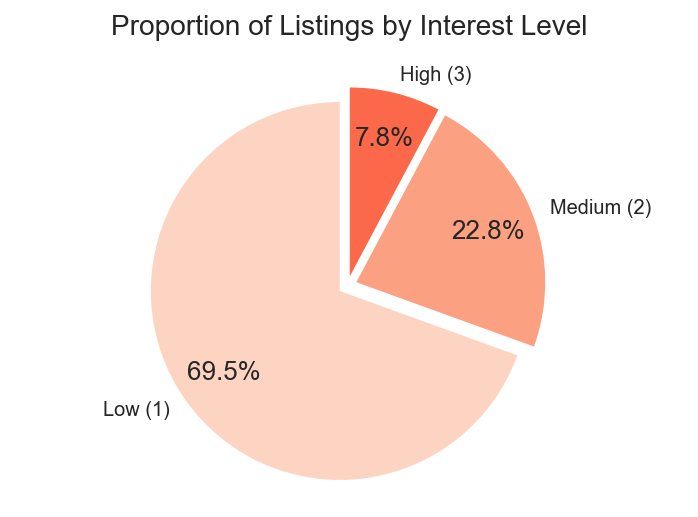

In [62]:
ax = plot_interest_pie(df.interest_level, textprops=dict(fontsize=13), pctdistance=.75)
ax.set_title(ax.get_title(), fontdict=dict(fontsize=14))

# plt.savefig(''.join([REPORT_IMG_DIR, '1-interest-pie.png']), dpi=600)
plt.show()


## Price

__Distribution__

count             inf
mean       3291.28121
std           1.54163
min          43.00000
25%        2500.00000
50%        3150.00000
75%        4100.00000
max     4490000.00000
Name: lg_price, dtype: float64

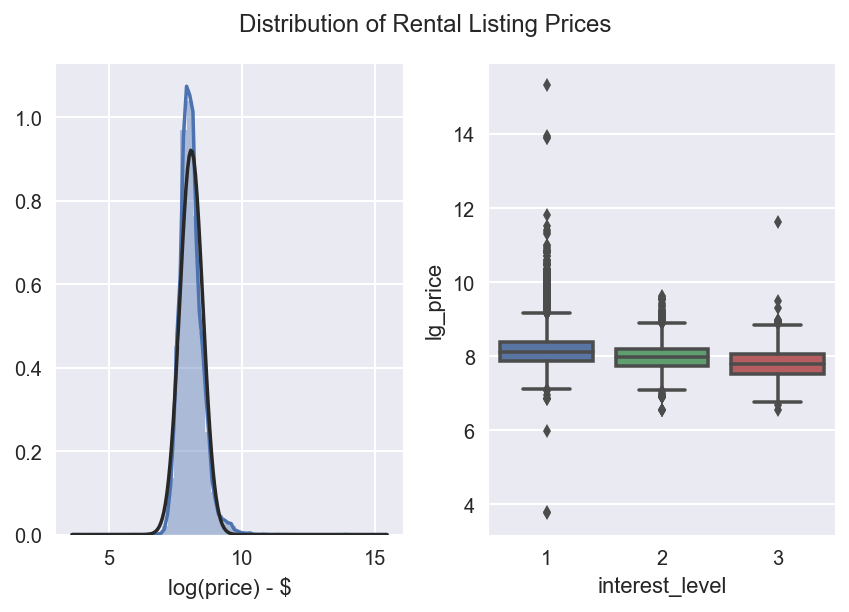

In [88]:
data = df.assign(lg_price=np.log(df.price))

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6, 4))
sns.distplot(data.lg_price, fit=stats.norm, ax=ax1)
ax1.set_xlabel('log(price) - $')

sns.boxplot(y='lg_price', x='interest_level', data=data, ax=ax2)
plt.suptitle('Distribution of Rental Listing Prices', y=1.05)

plt.tight_layout()

# Std not accurate given transformations
display(data.lg_price.describe().apply(np.exp))

__Missing__

In [65]:
df.price.sort_values().head(10)

listing_id
7060255     43
6813772     45
6871682    401
6865783    695
6852585    695
6831246    695
6859573    695
7127753    700
6934177    800
6952911    868
Name: price, dtype: int64

Can consider 43 and 45 vals as missing values

__Missing Data and Outliers__

In [67]:
k = 3
price_outls = df[is_price_outl(df.price, k=k)].price

n_outl = len(price_outls)
print('{} ({:.2%}) outliers found with Tukey test with k={}'
      .format(n_outl, n_outl/len(df), k))
display(price_outls.sort_values().head())
display(price_outls.sort_values().tail())

165 (0.33%) outliers found with Tukey test with k=3


listing_id
7060255       43
6813772       45
6871682      401
7179590    18295
7209856    18457
Name: price, dtype: int64

listing_id
6857401     135000
7013217    1070000
7036279    1070000
7208794    1150000
7208764    4490000
Name: price, dtype: int64

__Relevance__

In [197]:
data.lg_price.min()

6.543911845564792

lg_price chi2 p-val = 0.0000 (rounded)


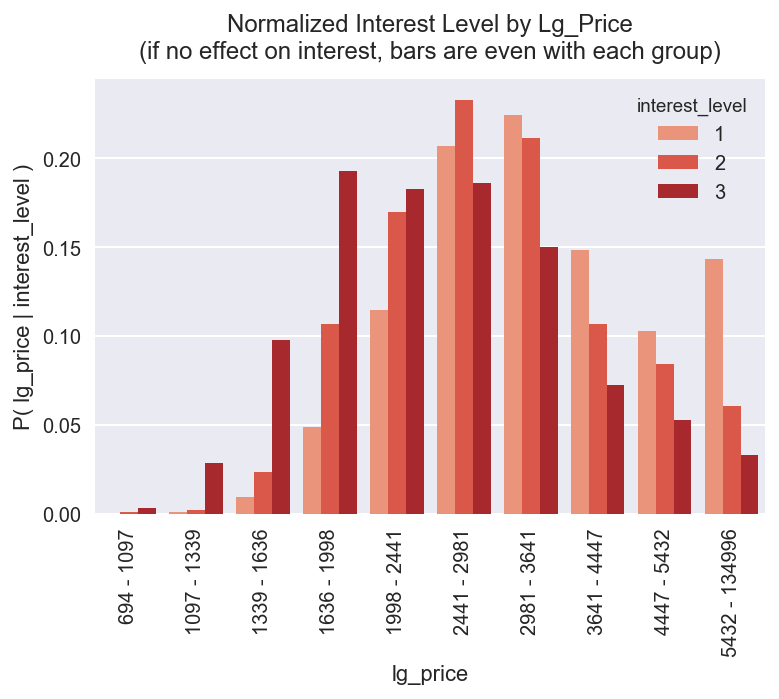

In [259]:
data = df.assign(lg_price=np.log(df.price))
data = PriceOutlierDropper().fit_transform(data)

bins = [data.lg_price.min(), 7, 7.2, 7.4, 7.6, 7.8, 8, 8.2, 8.4, 8.6,
        data.lg_price.max()]
plot_prob_x_for_hue(x='lg_price', data=data, hue='interest_level',
                    bins=bins, exp_xlabels=True)

# plt.savefig(''.join([REPORT_IMG_DIR, '2-price-on-interest.png']),
#             dpi=600, bbox_inches='tight')
plt.show()

## Bedrooms and Bathrooms

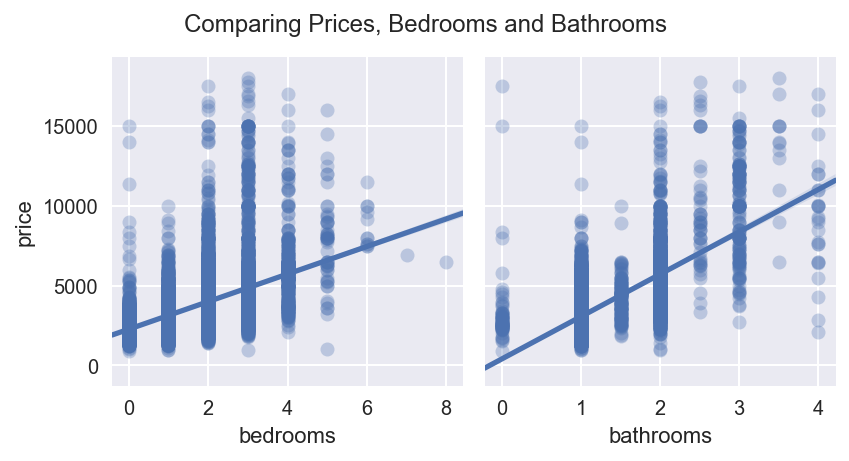

In [140]:
data = df[['bedrooms', 'bathrooms', 'price']]
data = drop_price_outl(data, k=3, msg=False)  # for plotting
data = data.sample(frac=.2, random_state=SEED)  # for performance

sns.pairplot(
    data=data,
    x_vars=['bedrooms', 'bathrooms'],
    y_vars=['price'],
    kind='reg',
    size=3,
    plot_kws=dict(scatter_kws=dict(alpha=.3)),
)
plt.suptitle('Comparing Prices, Bedrooms and Bathrooms', y=1.05)
plt.tight_layout()

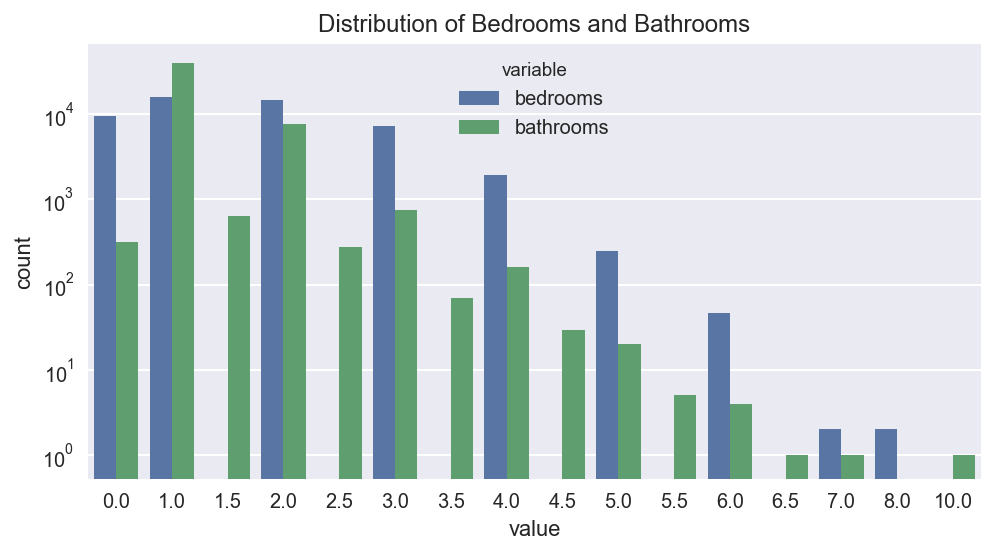

In [141]:
data = pd.melt(df, value_vars=['bedrooms', 'bathrooms'])
plt.figure(figsize=(8, 4))
ax = sns.countplot(x='value', hue='variable', data=data, log=True)
plt.title('Distribution of Bedrooms and Bathrooms')

# plt.savefig(''.join([REPORT_IMG_DIR, '4-bed-bath-dist.png']),
#             dpi=600, bbox_inches='tight')

plt.show()

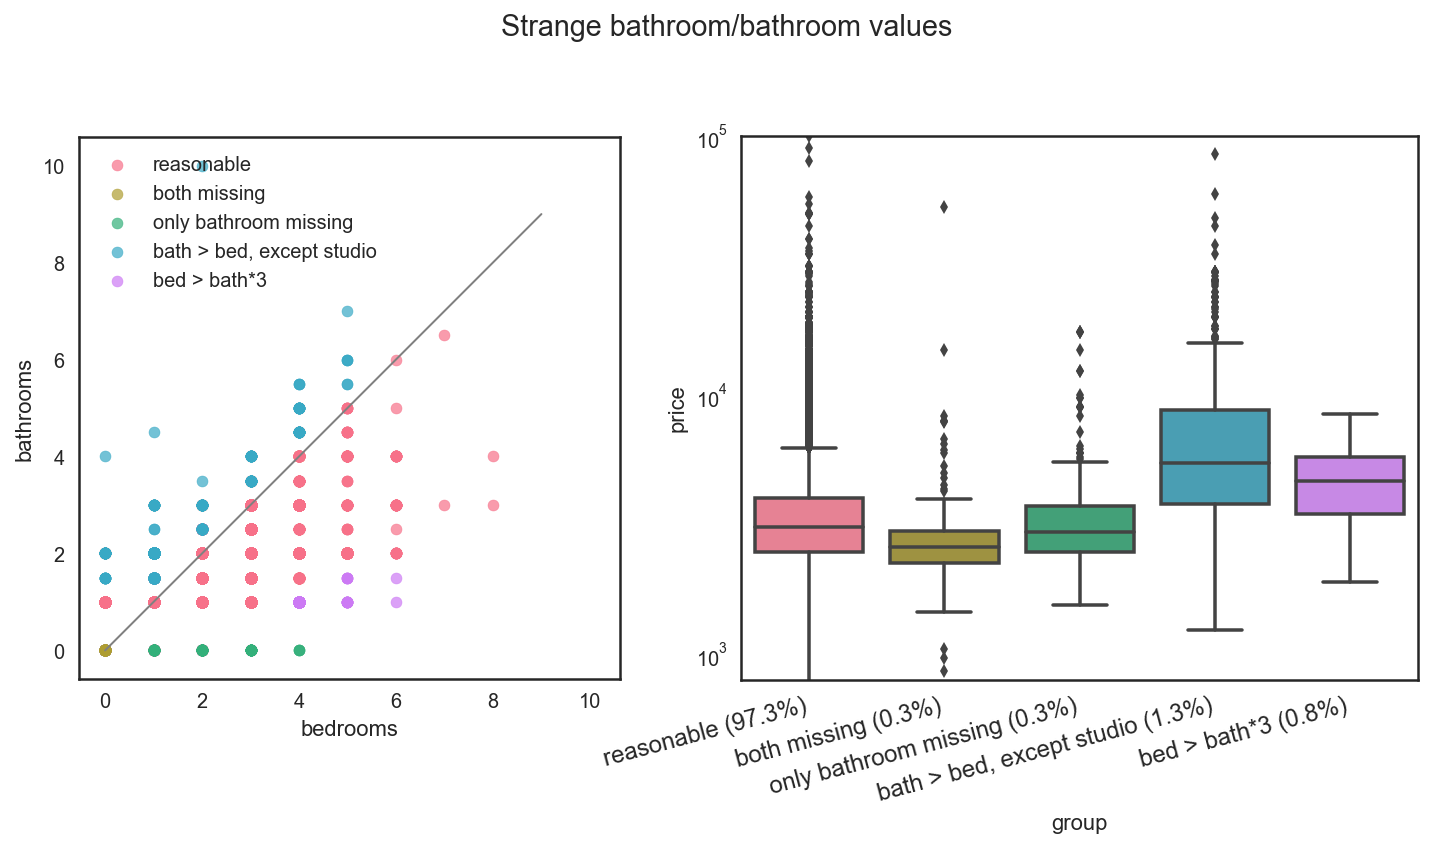

group counts


reasonable                   48023
bath > bed, except studio      634
bed > bath*3                   382
both missing                   157
only bathroom missing          156
Name: group, dtype: int64


Median Price by Group


group
bath > bed, except studio   5500.00000
bed > bath*3                4695.00000
both missing                2595.00000
only bathroom missing       2982.49057
reasonable                  3105.00000
Name: price, dtype: float64

In [142]:
data = set_bedbath_groups(df)

with sns.axes_style('white'):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5),
                                   gridspec_kw=dict(width_ratios=[4, 5]))

    grouped = data.groupby('group')
    
    group_order = ['reasonable', 'both missing', 'only bathroom missing',
                   'bath > bed, except studio', 'bed > bath*3']
    
    group_colors = sns.color_palette('husl', 5).as_hex()
    for color, name in zip(group_colors, group_order):
        group = grouped.get_group(name)
        group.plot(kind='scatter', x='bedrooms', y='bathrooms', label=name,
                   ax=ax1, color=color, s=30, alpha=.7)
    ax1.plot([0,9], [0,9], 'gray', linewidth=1)
    ax1.axis('square')
    ax1.legend(fontsize='medium')

    sns.boxplot(y='price', x='group', data=data,
                order=group_order, palette=group_colors, ax=ax2)

    xticklabels = []
    cnts = data.group.value_counts(normalize=True)
    for t in ax2.get_xticklabels():
        lbl = t.get_text()
        s = '{} ({:.1%})'.format(lbl, cnts[lbl])
        xticklabels.append(s)

    ax2.set_xticklabels(xticklabels, fontsize='large',
                        rotation=15, ha='right')
    ax2.set_yscale('log')
    ax2.set_ylim(800, 1e5)

    plt.suptitle('Strange bathroom/bathroom values', fontsize='x-large',
                 y=1.05)

    plt.savefig(''.join([REPORT_IMG_DIR, '3-strange-bed-bath.png']),
                dpi=600, bbox_inches='tight')
    plt.show()
    
print('group counts')
display(data.group.value_counts())
print()
print('Median Price by Group')
display(data.groupby('group')['price']
        .apply(lambda x: np.exp(np.median(np.log(x)))))

group chi2 p-val = 0.0000 (rounded)


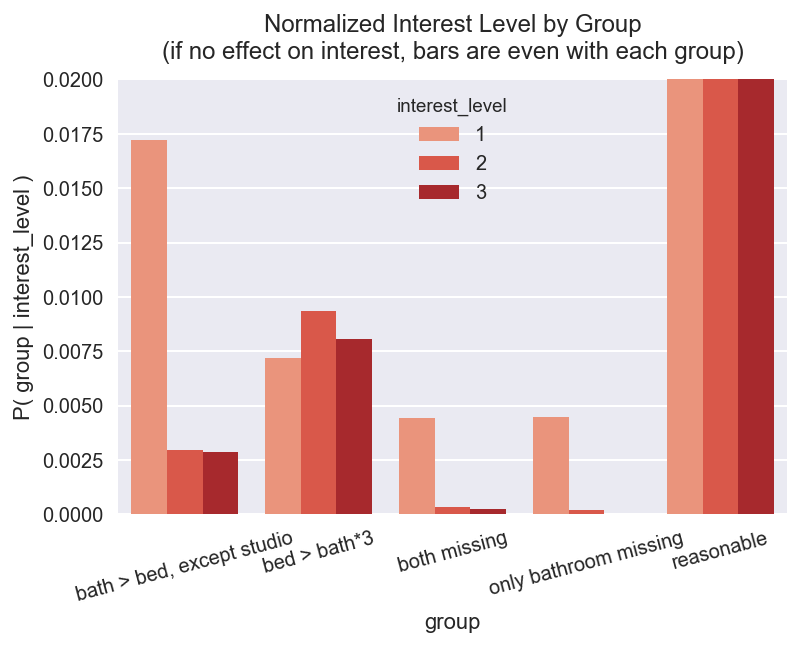

In [211]:
data = set_bedbath_groups(df)

ax = plot_prob_x_for_hue(x='group', data=data, hue='interest_level')
ax.set_xticklabels(ax.get_xticklabels(), rotation=15)
plt.ylim(0, .02)
plt.show()

bedrooms chi2 p-val = 0.0000 (rounded)


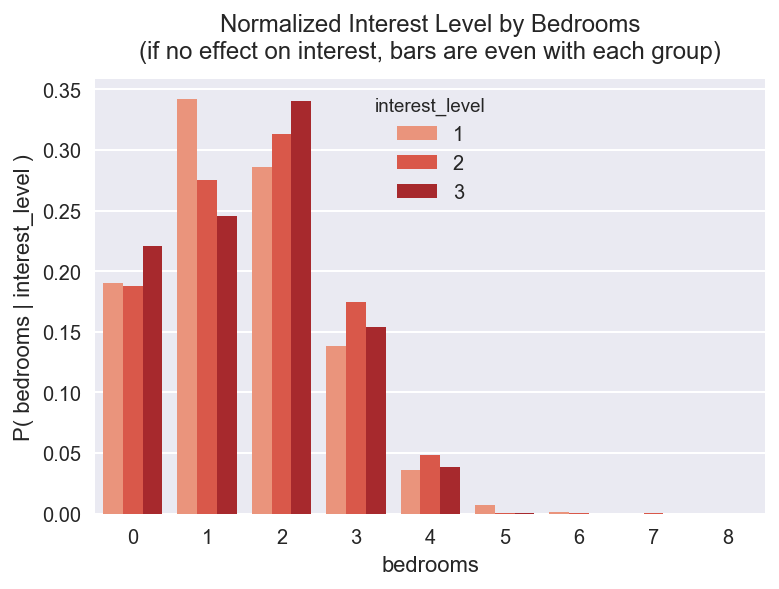

In [212]:
data = df
plot_prob_x_for_hue(x='bedrooms', data=data, hue='interest_level')
plt.show()

## Geo-coordinates and Buildings

In [217]:
df[df.latitude==0].shape

(12, 14)

Dropped 68 geo-coordinate outliers (0.14%)


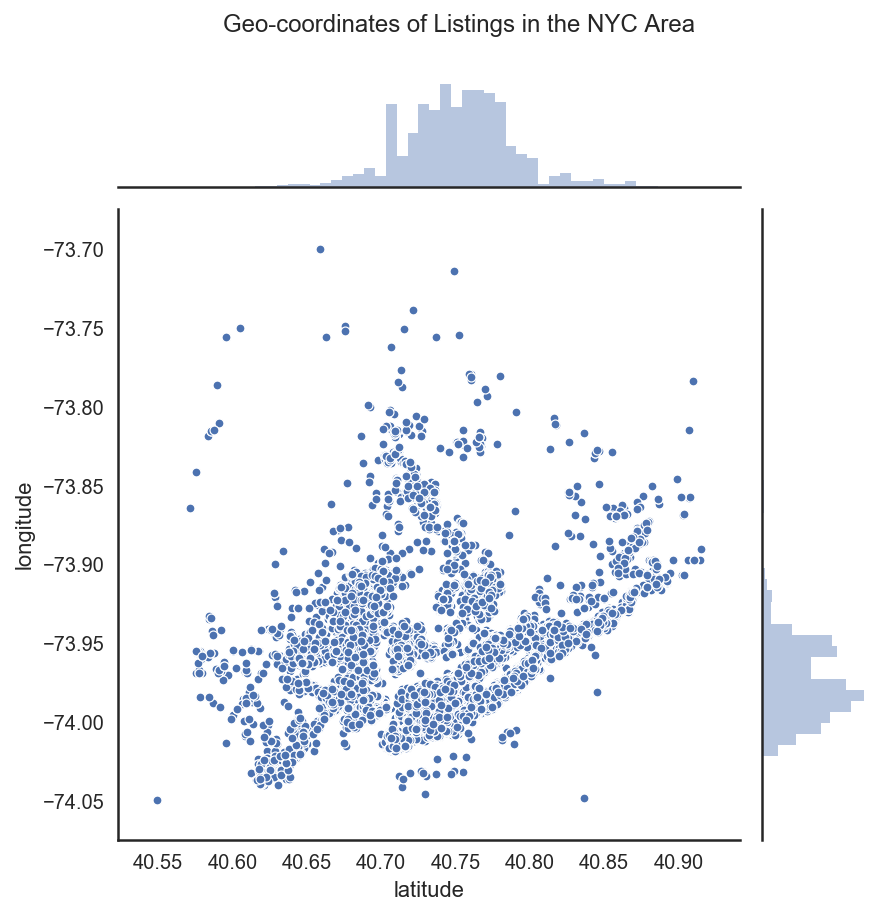

In [223]:
data = drop_geo_outl(df)
with sns.axes_style('white'):
    sns.jointplot('latitude', 'longitude', data=data, stat_func=None,
                  joint_kws=dict(edgecolor='w', lw=.6, s=20)
)
plt.suptitle('Geo-coordinates of Listings in the NYC Area', y=1.05)
# plt.savefig(''.join([REPORT_IMG_DIR, '5-geo-coordinates.png']),
#             dpi=600, bbox_inches='tight')
plt.show()

### Buildings vs Coordinates

Q: Is latitude and longitude determined by building?

A: No

In [120]:
print('Num buildings: {}'.format(len(df.building_id.unique())))
print('Num missing buildings: {}'.format(len(df[df.building_id=='0'])))

Num buildings: 7585
Num missing buildings: 8286


In [55]:
def has_same_coords(df):
    return df.duplicated(keep=False).all().all()

same_coords_dat = df.groupby('building_id')['latitude', 'longitude'].apply(
    lambda x: has_same_coords(x) if len(x) > 1 else np.nan
)
print('{} total buildings'.format(len(df.building_id.unique())))
print('{} only have one listing'.format((same_coords_dat.isnull()).sum()))
print('{} with same co-ordinates'.format(same_coords_dat.sum()))
print('{} with different co-ordinates'.format((same_coords_dat==False).sum()))

7585 total buildings
3659 only have one listing
2942 with same co-ordinates
984 with different co-ordinates


In [99]:
df[df.building_id=='0'].duplicated(['latitude', 'longitude'], keep=False).sum()

6291

How many geo-coordinate locations have multiple buildings?

In [117]:
building_diff = (df.groupby(['latitude', 'longitude'])['building_id']
                   .apply(lambda x: len(x.unique()))
                   .sort_values(ascending=False)
)

print((building_diff > 1).sum())
display(building_diff.head())

2219


latitude  longitude
0.00000   0.00000      11
40.71280  -74.00590     8
40.70690  -74.01040     4
40.74920  -73.97890     4
40.77920  -73.95140     4
Name: building_id, dtype: int64

How many buildings have listings with different geo-coordinates?

In [112]:
data = df.query('latitude != 0 and longitude != 0')
geo_coord_diff = (data.groupby('building_id')['latitude', 'longitude']
                    .apply(lambda x: x.max() - x.min())
)

print((geo_coord_diff.sum(1) > 0).sum())
display(geo_coord_diff.sort_values('latitude', ascending=False).head(20))
display(geo_coord_diff.sort_values('longitude', ascending=False).head(20))

1439


,latitude,longitude
building_id,,
cca9ed74339903b6d9c876a8e608d75b,4.12000,19.31200
0,2.91870,5.62760
437454e6d44ae7c94f60b1b6507d084a,0.91780,12.18180
ebdf422b8605d69a719a5cdc34019463,0.87690,0.66750
6869a3c2a96003e9992d6cd1c3c4b299,0.71720,1.53520
cd759a988b8f23924b5a2058d5ab2b49,0.16170,0.05060
3a6e1c689ffe82c668efccdcabb3664d,0.14260,0.07980
0dfc470e829c89405e597fd0bb9a4c55,0.07450,0.03260
b809c009c803e70c221317657ea96ec8,0.06700,0.08440


,latitude,longitude
building_id,,
cca9ed74339903b6d9c876a8e608d75b,4.12000,19.31200
437454e6d44ae7c94f60b1b6507d084a,0.91780,12.18180
0,2.91870,5.62760
6869a3c2a96003e9992d6cd1c3c4b299,0.71720,1.53520
95fabd330f806524ae62115264f1f840,0.02020,0.71240
ebdf422b8605d69a719a5cdc34019463,0.87690,0.66750
39dd015bc8b81e4ae8b667357b8620b4,0.03150,0.19900
c391084ee341be0d85643b7bd1757993,0.03850,0.13900
888101a642929bc225eae5f809a70bc8,0.02000,0.10890


Rounding geo-coordinates:
- Latitude
    - "Each degree of latitude is approximately 69 miles (111 kilometers) apart."
    - 5 ft = 0.00094697 miles = 0.000013724 degrees
    - 
- Longitude
    - "At 40° north or south, the distance between a degree of longitude is 53 miles (85 kilometers)."
    - 5 ft = 0.00094697 miles = 0.000017867 degrees


Source: https://www.thoughtco.com/degree-of-latitude-and-longitude-distance-4070616

## Dates

day_name chi2 p-val = 0.0000 (rounded)
month chi2 p-val = 0.3784 (rounded)


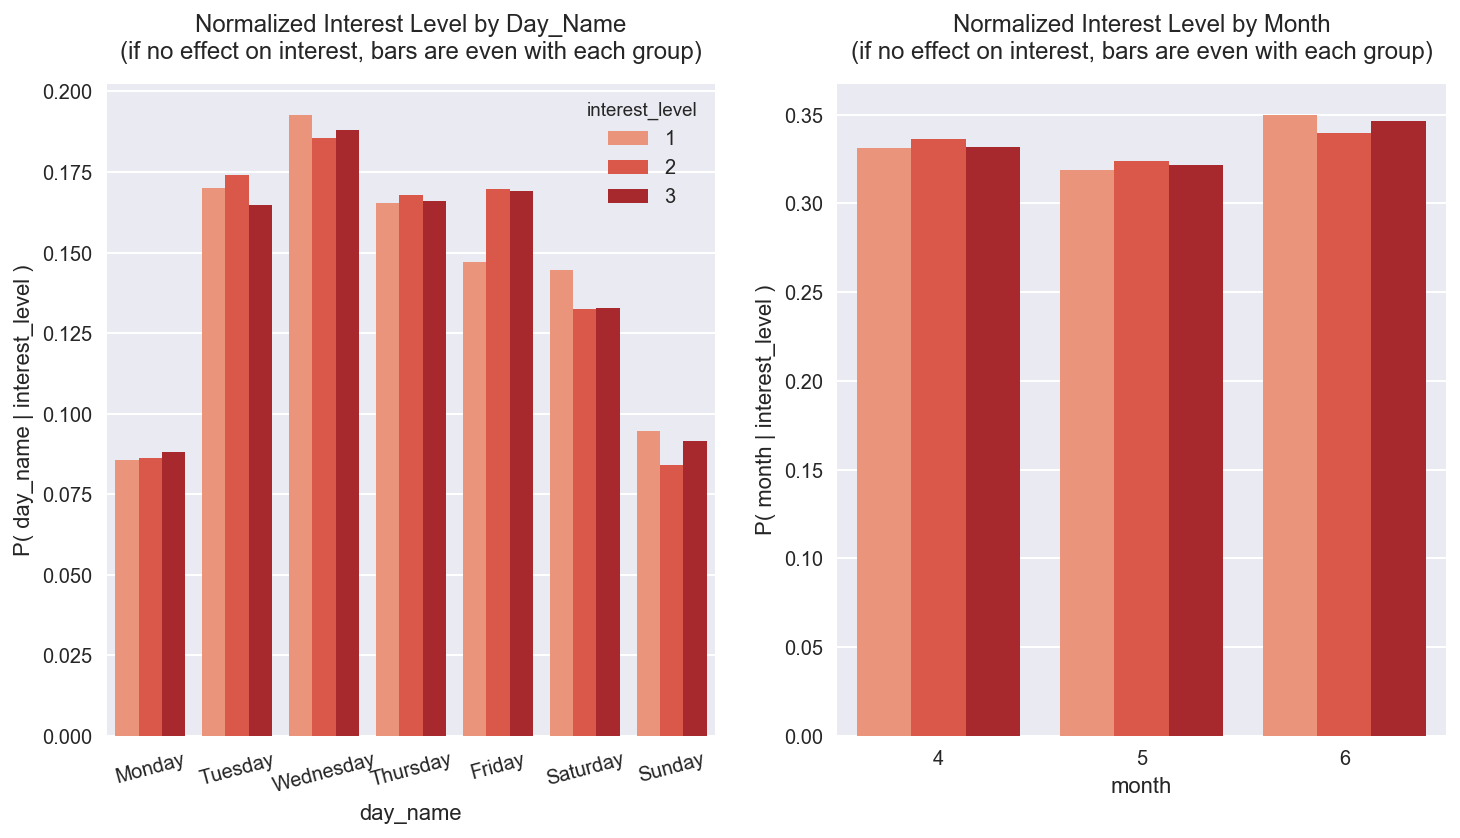

In [109]:
df['month']    = df.created.map(lambda x: x.month).astype(int)
df['day']      = df.created.map(lambda x: x.day).astype(int)
df['day_name'] = df.created.dt.weekday_name

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday',
             'Friday', 'Saturday', 'Sunday']

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
plot_prob_x_for_hue(x='day_name', data=df, hue='interest_level',
                    bins=None, order=day_order, ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15)

plot_prob_x_for_hue(x='month', data=df, hue='interest_level',
                    bins=None, ax=ax2)
ax2.legend('')

# plt.savefig(''.join([REPORT_IMG_DIR, '6-dates-on-interest.png']),
#             dpi=600, bbox_inches='tight')

plt.show()

In [10]:
days = [
    'created_Friday',
    'created_Monday',
    'created_Saturday',
    'created_Sunday',
    'created_Thursday',
    'created_Tuesday',
    'created_Wednesday']
ls = []
for day in days:
    ls.append("{}='',".format(day))
    
print('\n'.join(ls))

created_Friday='',
created_Monday='',
created_Saturday='',
created_Sunday='',
created_Thursday='',
created_Tuesday='',
created_Wednesday='',


In [111]:
columns = [
    'created_Friday',
    'created_Monday',
    'created_Saturday',
    'created_Sunday',
    'created_Thursday',
    'created_Tuesday',
    'created_Wednesday']

days = pd.DataFrame(DayBinarizer().fit_transform(df.created),
                    columns=columns)

['21.783%', '19.870%', '18.716%', '17.122%', '12.093%', '10.417%', '0.000%']


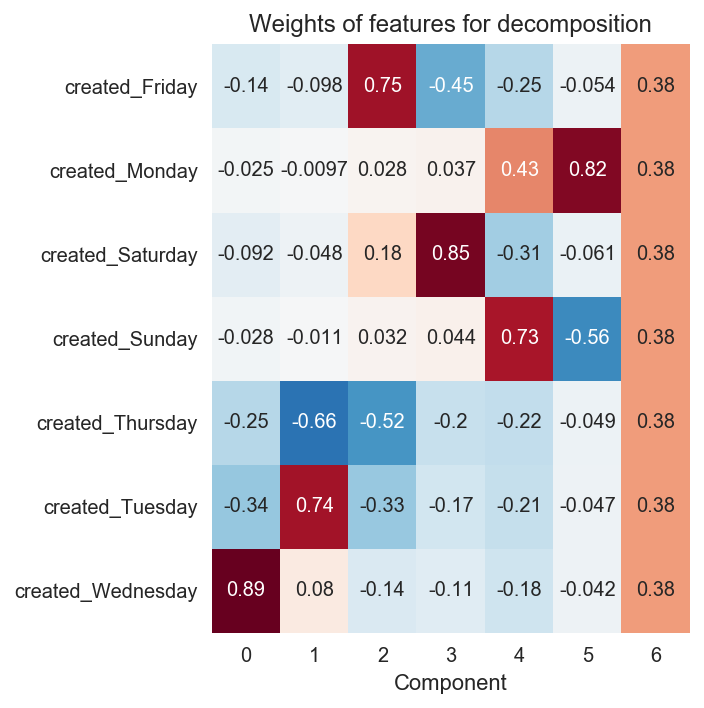

In [120]:
reducer = PCA()

reduced = reducer.fit_transform(days)
explained_variance = reducer.explained_variance_ratio_
print(['{:.3%}'.format(x) for x in explained_variance])

plt.figure(figsize=(5, 5))
sns.heatmap(reducer.components_.T, yticklabels=days.columns.tolist(),
            cbar=False, annot=True)

plt.title('Weights of features for decomposition')
plt.xlabel('Component')

plt.tight_layout();

## Addresses

In [512]:
df = read_rental_interest(DF_TRAIN_PKL)

Dropped 68 geo-coordinate outliers (0.14%)


How many missing display addresses have street addresses?

In [539]:
df[(df.street_address!='') & (df.display_address=='')].shape

(126, 14)

How many missing display addresses?

In [540]:
df[df.display_address==''].shape

(135, 14)

In [521]:
print('{} unique display addresses'.format(len(df.display_address.unique())))

8826 unique display addresses


In [522]:
df.display_address.value_counts().head()

Broadway            438
East 34th Street    355
Second Avenue       349
Wall Street         332
West 37th Street    287
Name: display_address, dtype: int64

How many listings have the same display address but different coordinates?

In [34]:
addr_cnts = df.groupby('display_address').apply(
    lambda x: len(x.latitude.unique()))

print((addr_cnts>1).sum())
display(addr_cnts.sort_values(ascending=False).head())

1951


display_address
                    117
Broadway             67
Second Avenue        63
First Avenue         56
Lexington Avenue     40
dtype: int64

## Number of photos

n_photos chi2 p-val = 0.0000 (rounded)


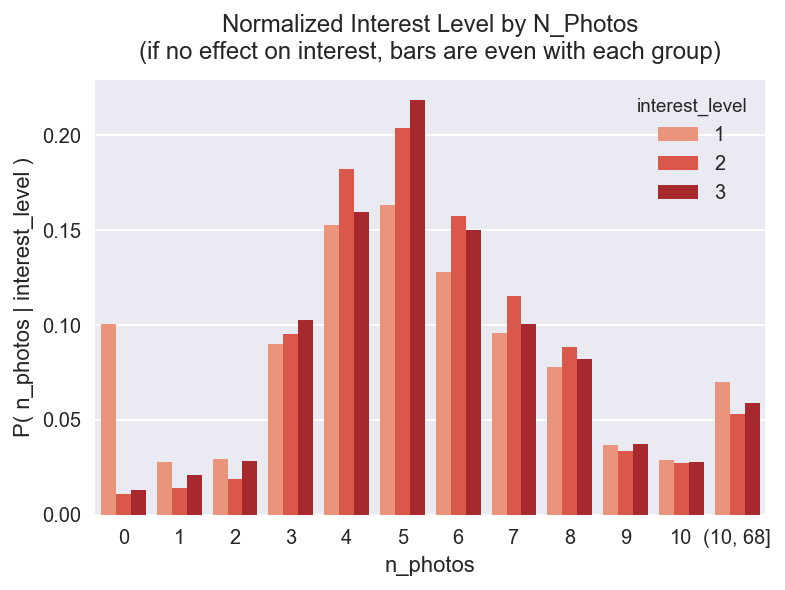

In [262]:
# do number of photos affect interest?
x = 'n_photos'
hue = 'interest_level'
data = df.assign(n_photos=df.photos.map(lambda x: len(x)))

bins = list(range(-1, 11)) + [data[x].max()]
ax = plot_prob_x_for_hue(x, data, hue, bins=bins)


ax.set_xticklabels(list(range(11)) + ['(10, 68]'], rotation=0)

# plt.savefig(''.join([REPORT_IMG_DIR, '7-n-photos-on-interest.png']),
#             dpi=600, bbox_inches='tight')

plt.show()

## Number of Features

n_feats chi2 p-val = 0.0000 (rounded)


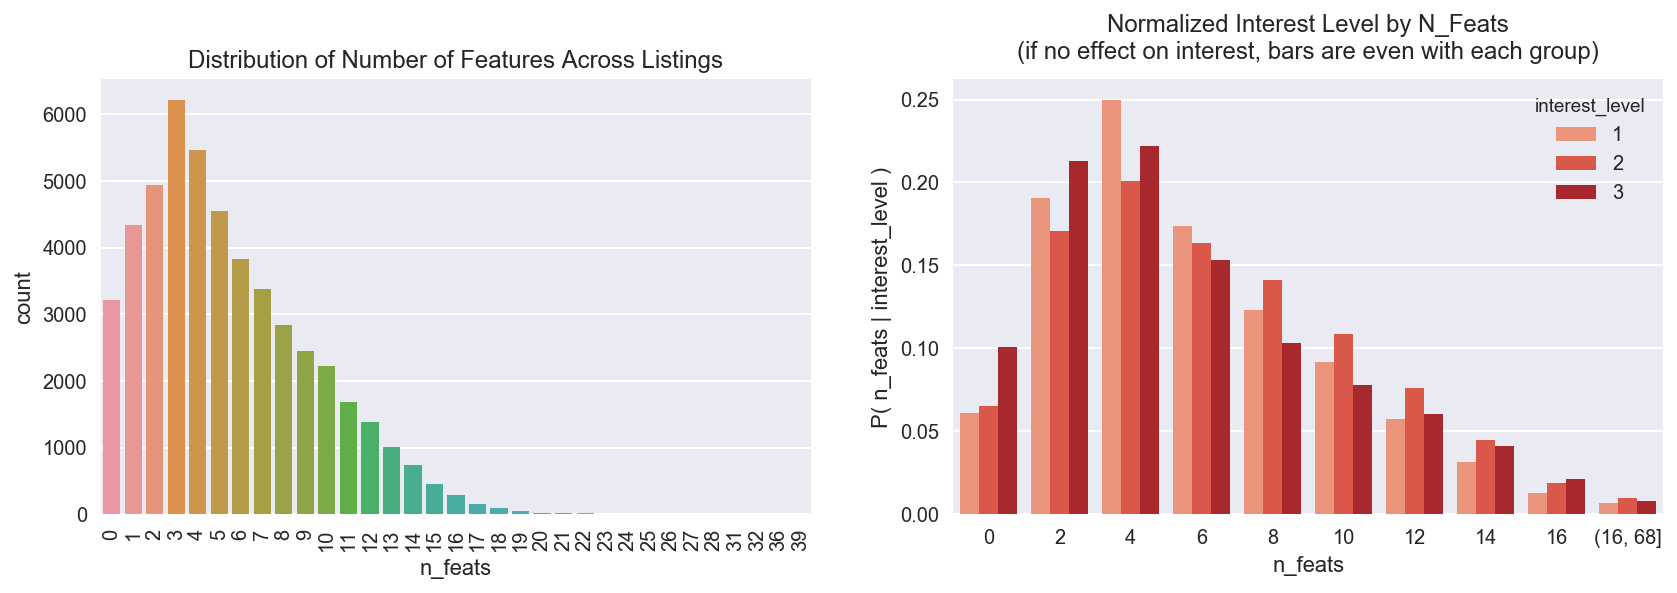

In [277]:
# do number of features affect interest?
data = df.assign(n_feats=df.features.apply(lambda x: len(x)))

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 4))

sns.countplot(data.n_feats, ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.set_title('Distribution of Number of Features Across Listings')

x = 'n_feats'
hue = 'interest_level'
bins = [-1] + list(range(0, 17, 2)) + [data[x].max()]
plot_prob_x_for_hue(x, data, hue, bins, ax=ax2)

ax2.set_xticklabels(list(range(0, 17, 2)) + ['(16, 68]'], rotation=0)

# plt.savefig(''.join([REPORT_IMG_DIR, '8-n-feats-on-interest.png']),
#             dpi=600, bbox_inches='tight')

plt.show()

## Description Word Count

descr_wcnt chi2 p-val = 0.0000 (rounded)


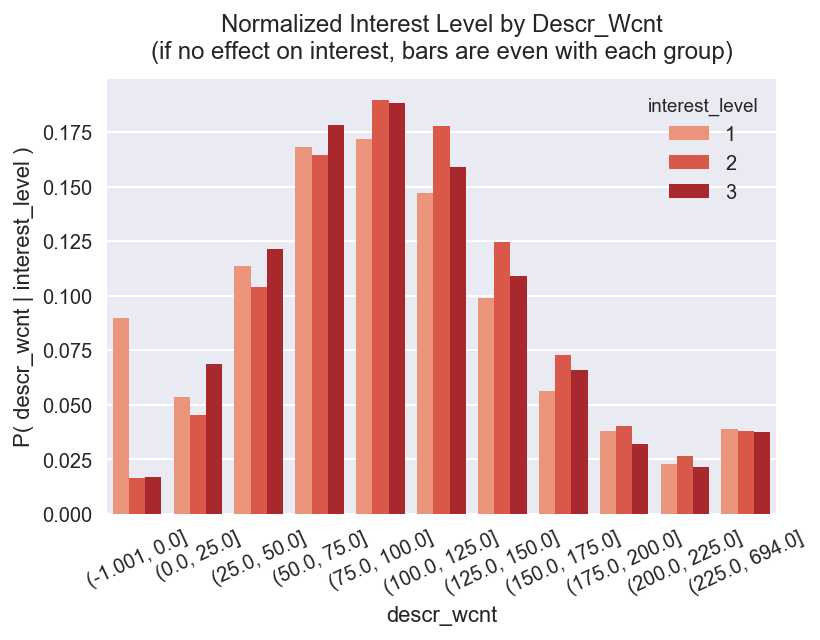

In [278]:
# does length of description affect interest?
data = df.assign(descr_wcnt=df.description.apply(get_word_cnt))
x = 'descr_wcnt'
hue = 'interest_level'

bins = [-1] + list(range(0, 226, 25)) + [data.descr_wcnt.max()]
plot_prob_x_for_hue(x=x, data=data, hue=hue, bins=bins)

plt.xticks(rotation=25)

# plt.savefig(''.join([REPORT_IMG_DIR, '9-descrip-wcnt-on-interest.png']),
#             dpi=600, bbox_inches='tight')

plt.show()

### Scaling of count features

In [70]:
scl_len_mapper = DataFrameMapper([
    ('photos', [LenExtractor(), StandardScaler()],
         {'alias': 'n_photos'}),
    ('features', [LenExtractor(), SqrtTransformer(), StandardScaler()],
         {'alias': 'n_feats'}),
    ('description', [WordCntExtractor(), SqrtTransformer(), StandardScaler()],
         {'alias': 'descr_wcnt'}),
], input_df=True, df_out=True)


data = scl_len_mapper.fit_transform(df)

fig, axs = plt.subplots(nrows=3, figsize=(5, 10))

for (_, ser), ax in zip(data.items(), axs):
    sns.distplot(ser, ax=ax)

/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


## Manager Activity and Performance

- Total posts
- Posts/duration
- Rating/post

In [3]:
df = read_rental_interest(DF_TRAIN_PKL)

n_posts chi2 p-val = 0.0000 (rounded)


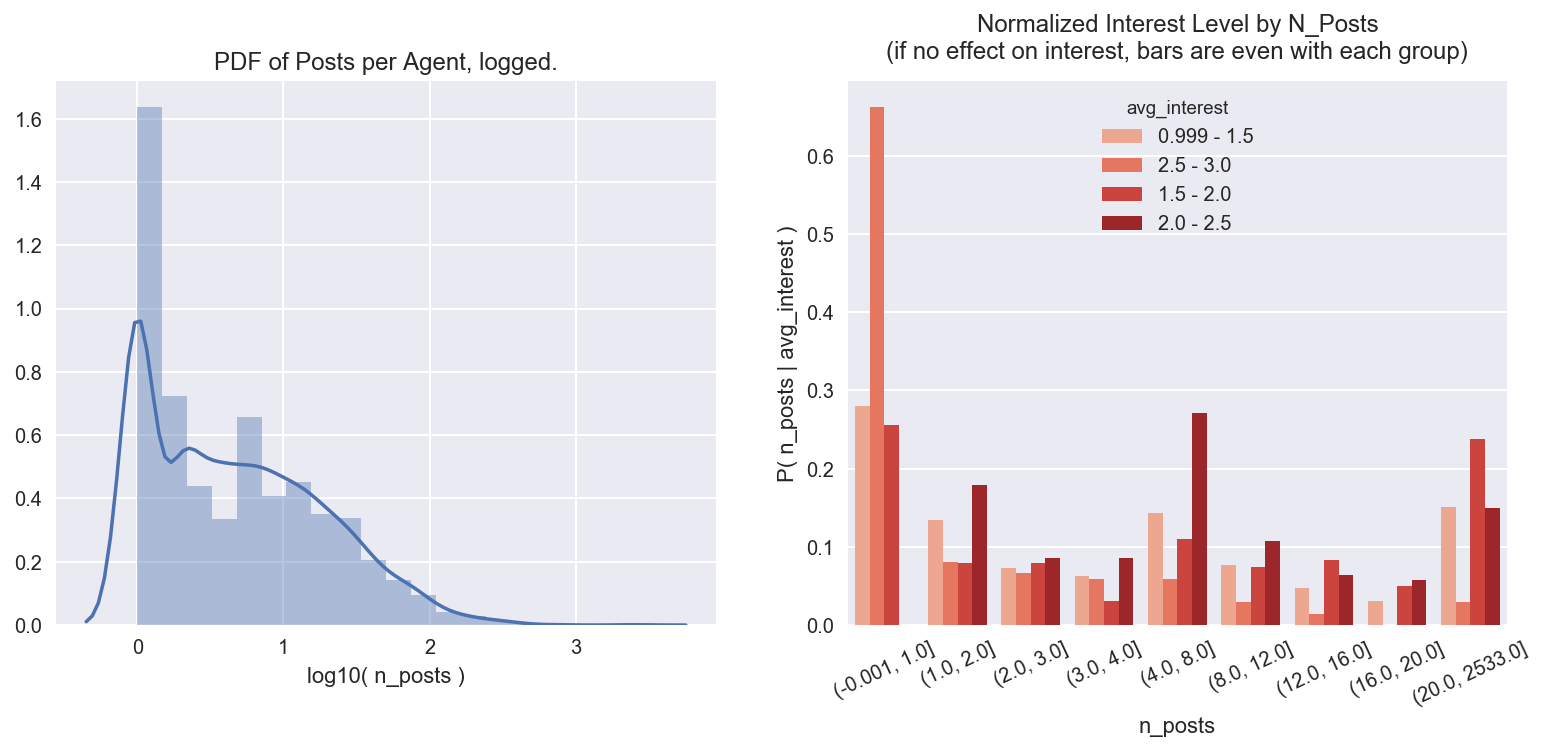

In [56]:
# see if activity of agents affects interest

prior = df.interest_level.mean()
avg_int = (df.groupby('manager_id')['interest_level']
#            .apply(exp_int, prior)
           .mean()
           .rename('avg_interest')
)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13, 5))
n_posts = df.manager_id.value_counts().rename('n_posts')

ax1 = sns.distplot(np.log10(n_posts), bins=20, ax=ax1)

ax1.set_xlabel('log10( n_posts )')
ax1.set_title('PDF of Posts per Agent, logged.')

data = pd.concat([n_posts, avg_int], axis=1)
x = 'n_posts'
hue = 'avg_interest'

bins = [0, 1, 2, 3] + list(range(4, 24, 4)) + [data.n_posts.max()]
hue_bins = [1, 1.5, 2, 2.5, 3]
ax2= plot_prob_x_for_hue(x=x, data=data, hue=hue, bins=bins,
                          hue_bins=hue_bins, ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=25)

# plt.savefig(''.join([REPORT_IMG_DIR, '10-n-posts-on-avg-interest.png']),
#             dpi=600, bbox_inches='tight')

plt.show()

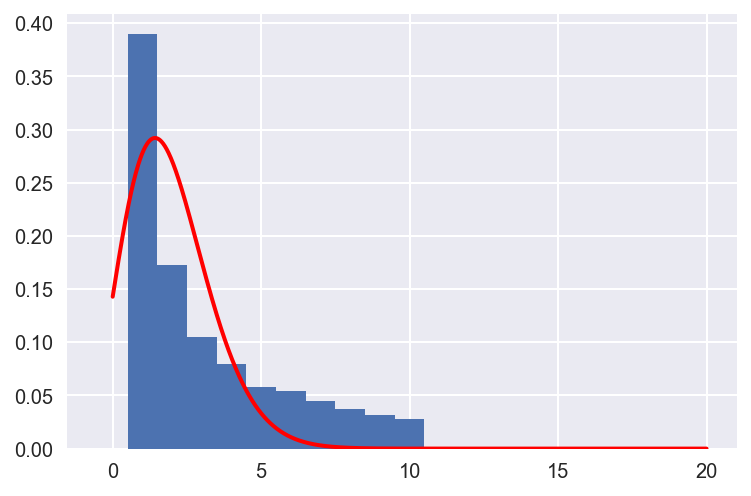

In [54]:

# Source: https://stackoverflow.com/questions/25828184/fitting-to-poisson-histogram

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.misc import factorial


# get poisson deviated random numbers
data = n_posts

# the bins should be of integer width, because poisson is an integer distribution
entries, bin_edges, patches = plt.hist(data, bins=11, range=[-0.5, 10.5], normed=True)

# calculate binmiddles
bin_middles = 0.5*(bin_edges[1:] + bin_edges[:-1])

# poisson function, parameter lamb is the fit parameter
def poisson(k, lamb):
    return (lamb**k/factorial(k)) * np.exp(-lamb)

# fit with curve_fit
parameters, cov_matrix = curve_fit(poisson, bin_middles, entries) 

# plot poisson-deviation with fitted parameter
x_plot = np.linspace(0, 20, 1000)

plt.plot(x_plot, poisson(x_plot, *parameters), 'r-', lw=2)
plt.show()

## Building Activity and Performance

#### Listing counts by building (i.e. building activity)

In [124]:
df.query("building_id != '0'").shape

(41066, 14)

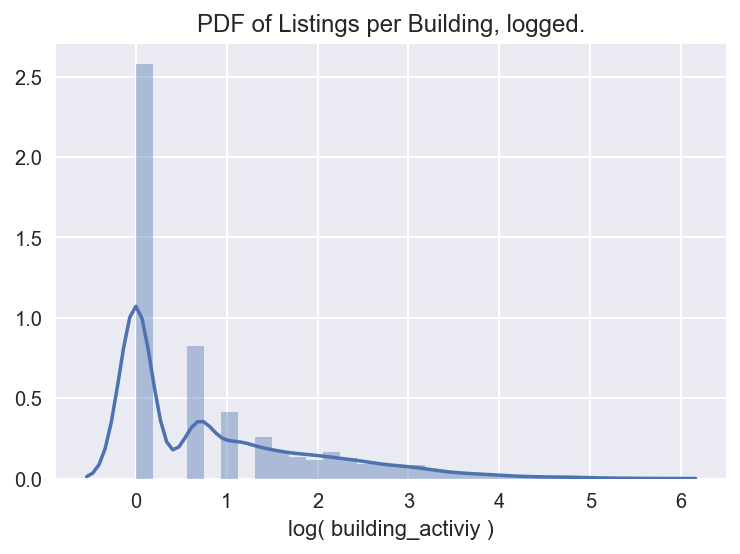

In [48]:
building_activiy = (df.query("building_id != '0'")
                      .building_id.value_counts()
                      .rename('building_activiy')
)

sns.distplot(np.log(building_activiy), bins=30)
plt.xlabel('log( building_activiy )')
plt.title('PDF of Listings per Building, logged.')

In [322]:
a, b = 4+4, 3

In [133]:
data.building_activiy.max()

2533.0

In [59]:
# see if activity of agents affects interest

prior = df.groupby('building_id')['interest_level'].mean().mean()
avg_int = (df.groupby('building_id')['interest_level']
             .apply(exp_int, prior)
             .rename('avg_interest')
)

building_activiy = df.manager_id.value_counts().rename('building_activiy')
data = pd.concat([building_activiy, avg_int], axis=1)

bins = [0, 1, 2, 3, 4, 6, 8, 12, 16, 25, 30, data.building_activiy.max()]

x = 'building_activiy'
hue = 'avg_interest'

hue_bins = [1, 1.5, 2, 2.5, 3]

plot_prob_x_for_hue(x=x, data=data, hue=hue, bins=bins, hue_bins=hue_bins)

# plt.savefig(''.join([REPORT_IMG_DIR, '11-building-act-on-avg-interest.png']),
#             dpi=600, bbox_inches='tight')

plt.show()

ValueError: Some x values fall outside bins.

## Feature Importance

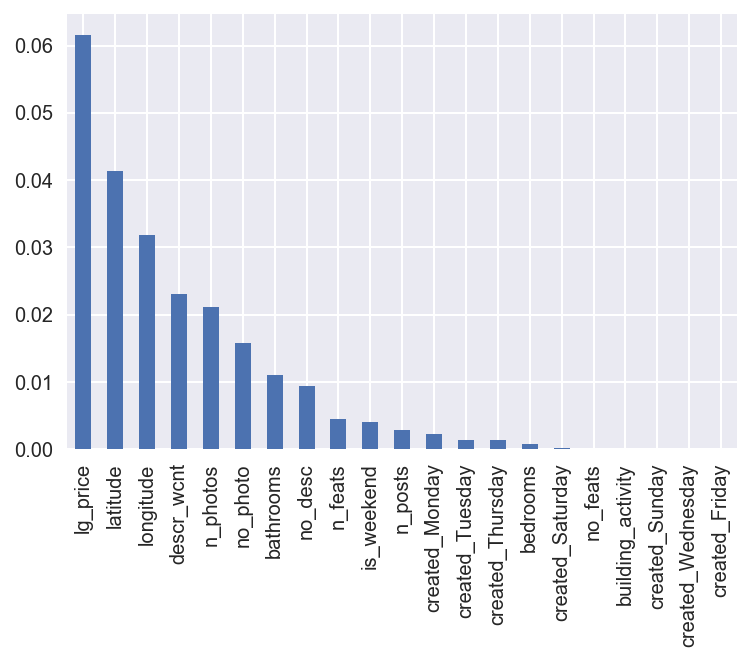

In [83]:
df = read_rental_interest(DF_TRAIN_PKL)

X, y = df.drop('interest_level', axis=1), df.interest_level

X_ = feature_prep(X)
X_ = extractor.fit_transform(X_)

discrete_features = [5]  # for boolean is_weekend
info = mutual_info_classif(X_, y, discrete_features=discrete_features,
                           random_state=SEED)
mi = pd.Series(info, index=columns).sort_values(ascending=False)
mi.plot('bar')

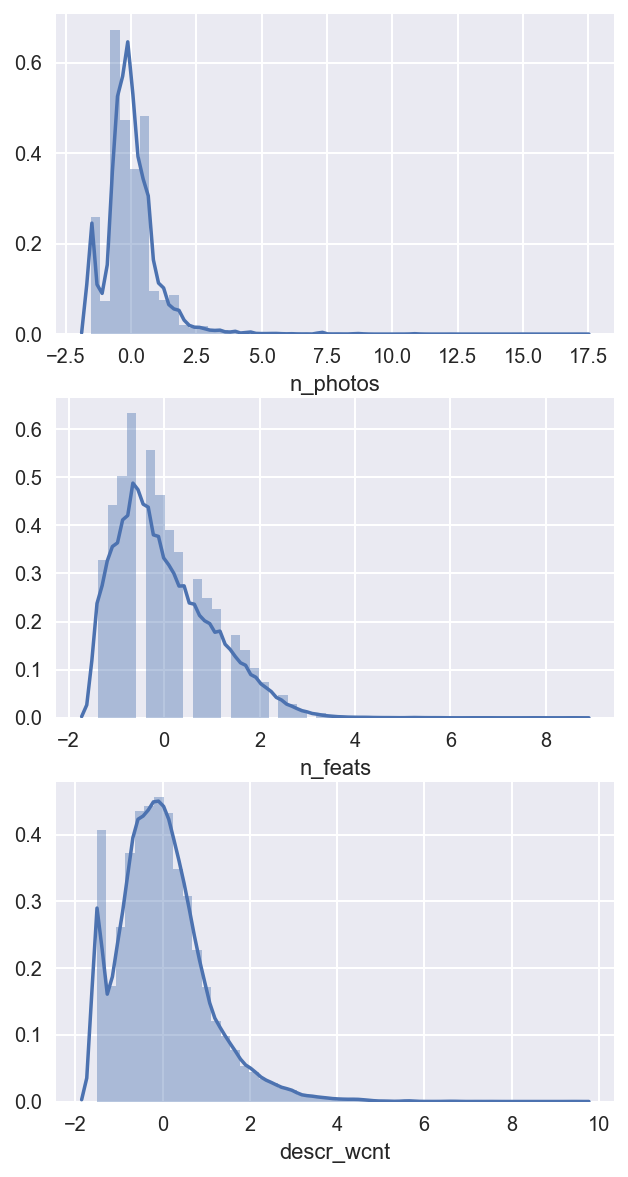

In [64]:
fig, axs = plt.subplots(nrows=3, figsize=(5, 10))

for (_, ser), ax in zip(data.items(), axs):
    sns.distplot(ser, ax=ax)

In [ ]:
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=200, n_jobs=-1, random_state=SEED)
forest.fit(X, y)


arr = np.vstack([tree.feature_importances_ for tree in forest.estimators_])
data = pd.DataFrame(arr, columns=X.columns)
data = data.reindex(columns=data.mean().sort_values(ascending=False).index)


sns.barplot(data=data)
plt.title('Feature importances')
plt.xticks(rotation=75)
plt.show()

## PCA

['22.461%', '17.837%', '15.471%', '12.635%', '7.539%', '4.877%', '4.054%', '2.924%', '2.785%', '2.661%', '1.664%', '1.524%', '1.428%', '0.986%', '0.854%', '0.299%', '0.000%', '0.000%']


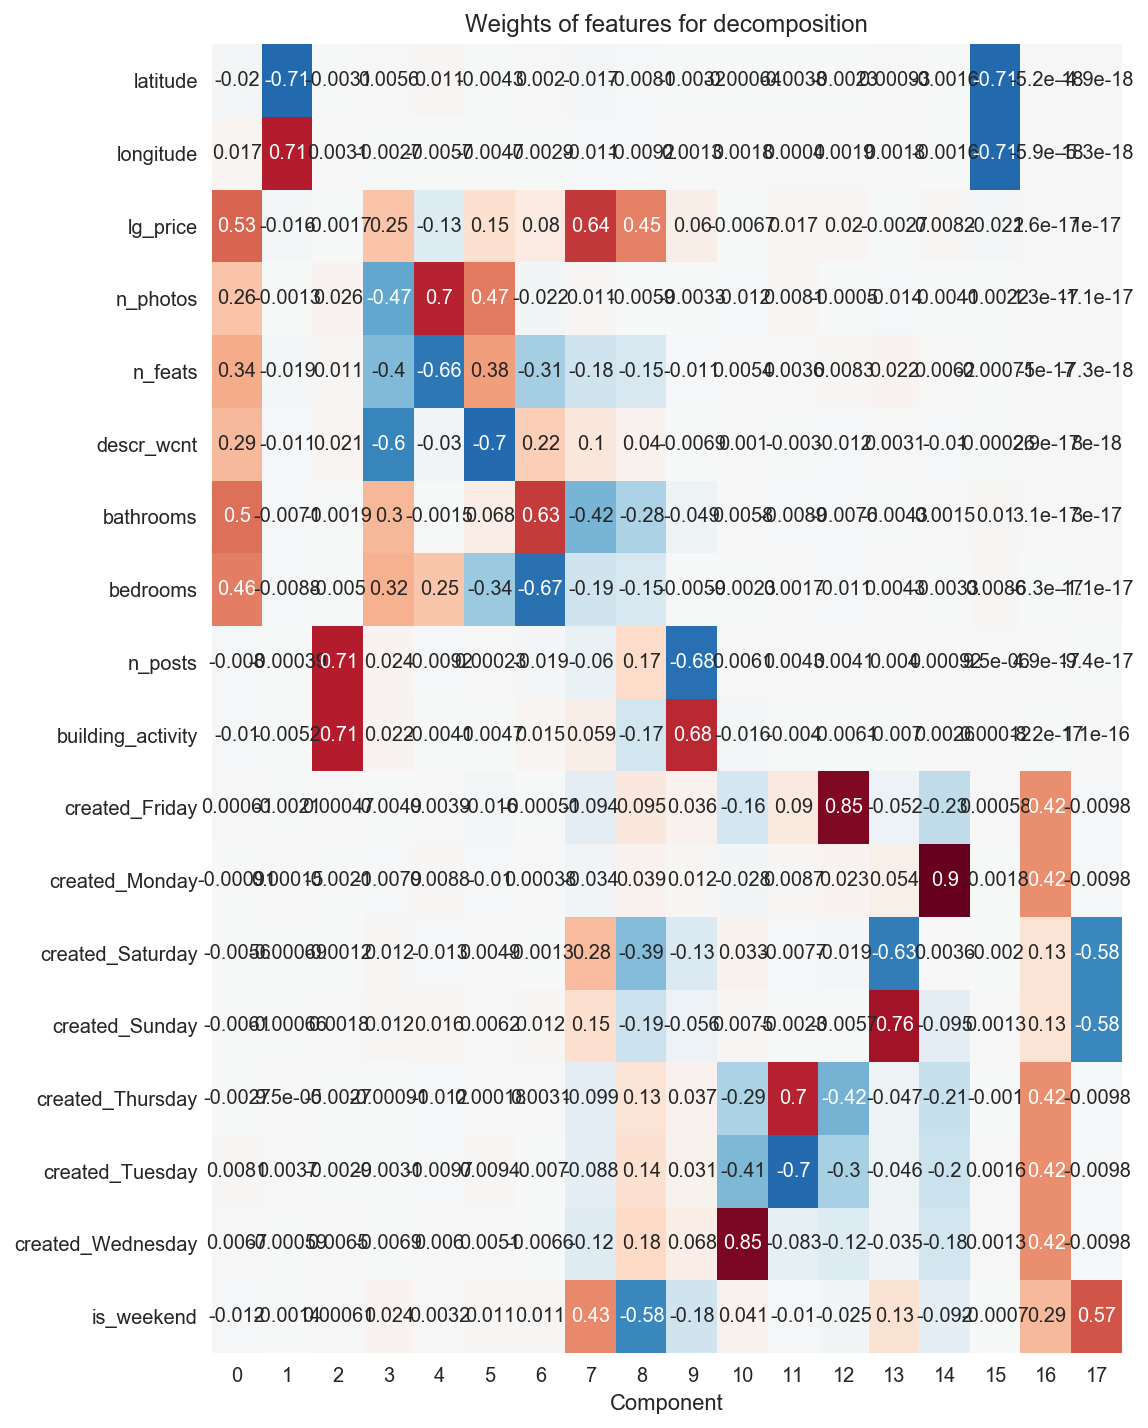

In [131]:
columns = [
    'latitude', 'longitude', 'lg_price', 'n_photos', 'n_feats',
    'descr_wcnt', 'bathrooms', 'bedrooms', 'n_posts', 'building_activity',
]

X = extractor.fit_transform(feature_prep(df))[:, :-8]

reducer = PCA()

reduced = reducer.fit_transform(X)
explained_variance = reducer.explained_variance_ratio_
print(['{:.3%}'.format(x) for x in explained_variance])

plt.figure(figsize=(8, 10))
sns.heatmap(reducer.components_.T, yticklabels=columns[:-8],
            cbar=False, annot=True)

plt.title('Weights of features for decomposition')
plt.xlabel('Component')

plt.tight_layout();

In [326]:
from scipy.cluster import hierarchy

ytdist = np.array([662., 877., 255., 412., 996., 295., 468., 268.,
                   400., 754., 564., 138., 219., 869., 669.])
Z = hierarchy.linkage(X, 'single')
plt.figure()
dn = hierarchy.dendrogram(Z)

hierarchy.set_link_color_palette(['m', 'c', 'y', 'k'])
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
dn1 = hierarchy.dendrogram(Z, ax=axes[0], above_threshold_color='y',
                           orientation='top')
dn2 = hierarchy.dendrogram(Z, ax=axes[1], above_threshold_color='#bcbddc',
                           orientation='right')
hierarchy.set_link_color_palette(None)  # reset to default after use
plt.show()

NameError: name 'X' is not defined

In [35]:
from hdbscan import HDBSCAN


clusterer = HDBSCAN().fit(X)

In [36]:
two_d = reduced[:, :2]

with sns.axes_style('white'):
    sns.lmplot(*two_d.T, hue=clusterer.labels_,
                scatter_kws=dict(edgecolor='w', lw=.6, s=20)
)
plt.show()

TypeError: lmplot() missing 1 required positional argument: 'data'

# Learning

## Notes

__About the target variable__:
- From Kaggle: "The target variable, interest_level, is defined by the number of inquiries a listing has in the duration that the listing was live on the site."
- This means listings taken down quickly due to a quick close will be classified with the same interest level as one that takes longer to close and has the same number of inquiries.
- If we take a more holistic approach to interest level, another distortion could arise with listings that have lots of inquiries due to listings that are higher quality relative to the actual property.
- Ultimately, the distorting factor of duration is unknown because, assuming the listing were shown as they are now, the search ranking is determined not only by "freshness" but also by the quality of the posting and the property itself (possibly derived from interest level). 

__Dealing with class imbalance__:
- High: 0.078, medium: 0.228, low: 0.695
- https://stats.stackexchange.com/questions/122409/why-downsample
- For probabilistic models, we need that informatation of the imbalance!
- If balance, logloss worse than benchmark

__Logistic Regression__
- Cost function favors majority class, but so does the class distribution!
- ~~`Sklearn` implementation has `weight` parameter with `balanced` option.~~

__Dealing with outliers__:
- Examine with HDBSCAN
- Look at classes of outliers

__Logistic Regression__:
- http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
- `Liblinear` only compatible with `ovr`, use others for `multinomial`
- For build-in CV for regularization strength, use: [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV)

__Gradient boosted trees__:
- 

Stochastic Gradient Descent with modified huber loss:
- using sklearn's [`SGDClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
- `modified_huber` is another smooth loss that brings tolerance to outliers as well as probability estimates

__Train test split__

- 

## Spot-check algorithms

Random guessing score:

In [3]:
df = read_rental_interest(DF_TRAIN_PKL)
y = LabelBinarizer().fit_transform(df.interest_level)

avg_probs = (np.sum(y, axis=0)/len(y)).tolist()
baseline_pred = np.array(avg_probs*len(y)).reshape(-1, 3)
baseline_score = log_loss(y, baseline_pred)
baseline_score

0.78857691143225461

### Spot-check

In [4]:
df = read_rental_interest(DF_TRAIN_PKL)

X, y = df.drop('interest_level', axis=1), df.interest_level

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.35, random_state=SEED, stratify=y)

### Algorithm: `Logistic Regression`

In [24]:
from preprocessing import *
from main import *


columns = [
    'latitude', 'longitude', 'lg_price', 'n_photos', 'n_feats',
    'descr_wcnt', 'bathrooms', 'bedrooms', 'n_posts', 'building_activity',
    'created_Friday', 'created_Monday', 'created_Saturday',
    'created_Sunday', 'created_Thursday', 'created_Tuesday',
    'created_Wednesday', 'no_photo', 'no_feats', 'no_desc'
]

In [6]:
from main import read_rental_interest
df = read_rental_interest(DF_TRAIN_PKL)

X, y = df.drop('interest_level', axis=1), df.interest_level

X_prepped = feature_prep(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_prepped, y, test_size=.20, random_state=SEED, stratify=y)

pipe = Pipeline([
    ('extractor', extractor),
    ('lr_clf', LogisticRegression(
        random_state=SEED, multi_class='multinomial',
        warm_start=True, max_iter=100, 
        solver='lbfgs'))
])

parameters = dict(
    lr_clf__C=np.logspace(-4, 4, 5),
    lr_clf__solver=['lbfgs'],
)

# cv = StratifiedShuffleSplit(n_splits=5, train_size=.4, random_state=SEED)
grid = GridSearchCV(pipe, parameters, n_jobs=1, scoring=scoring,
                    error_score=np.nan, cv=None)


grid.fit(X_train, y_train)

print(best_grid_results(grid))

Best score: -0.69151

*** For parameters: ***
lr_clf__solver: lbfgs
lr_clf__C: 1.0


In [ ]:
g = GridSearchExplorer(grid)

In [ ]:
g.plot(x='lr_clf__C', hue='lr_clf__C')

Train score:   -0.69030
Test score :   -0.68610


Process ForkPoolWorker-18:
Process ForkPoolWorker-20:
Process ForkPoolWorker-21:
Process ForkPoolWorker-19:
Process ForkPoolWorker-16:
Process ForkPoolWorker-23:
Process ForkPoolWorker-17:
Process ForkPoolWorker-22:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/multiprocessing/proc

KeyboardInterrupt: 

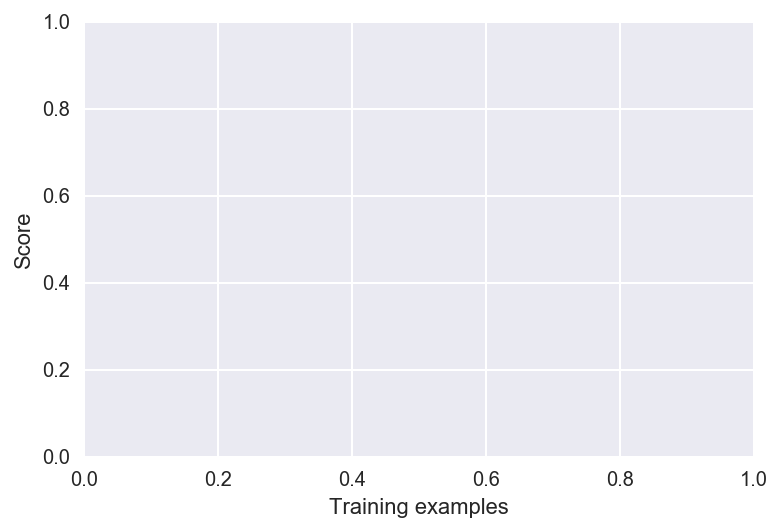

In [4]:
clf = grid.best_estimator_

y_pred = clf.predict_proba(X_train)
print('Train score: {:>10.5f}'.format(-log_loss(y_train, y_pred)))

y_pred = clf.predict_proba(X_test)
print('Test score : {:>10.5f}'.format(-log_loss(y_test, y_pred)))

plot_learning_curve(clf,
                    X_train, y_train,
                    scoring=scoring,
                    n_jobs=4);

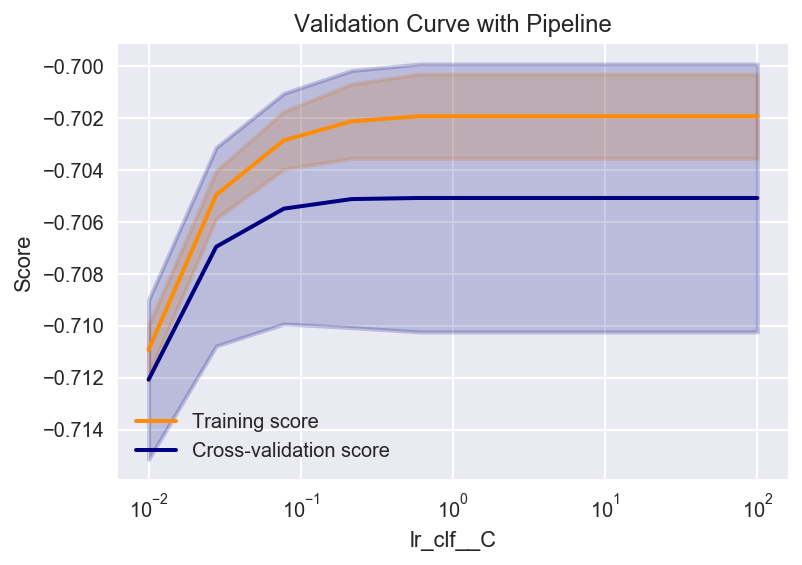

In [23]:
clf = grid.best_estimator_

cv = StratifiedShuffleSplit(n_splits=5, train_size=.4, random_state=SEED)
kwargs = dict(estimator=clf, X=X_train, y=y_train,
              param_name='lr_clf__C', param_range=np.logspace(-2, 2, 10),
              scoring=scoring, cv=cv, n_jobs=1)
plot_validation_curve(**kwargs).set_xscale('log');

### Algorithm: `pyglmnet`

In [2]:
columns = [
    'latitude', 'longitude', 'lg_price', 'n_photos', 'n_feats',
    'descr_wcnt', 'bathrooms', 'bedrooms', 'n_posts', 'building_activity',
    'created_Friday', 'created_Monday', 'created_Saturday',
    'created_Sunday', 'created_Thursday', 'created_Tuesday',
    'created_Wednesday', 'no_photo', 'no_feats', 'no_desc'
]

In [39]:
sig_clf.fit(X_train[['bedrooms', 'bathrooms']], y_train)
sig_clf.predict_proba(X_train[['bedrooms', 'bathrooms']])

array([[ 0.54004786,  0.36352117,  0.09643097],
       [ 0.60705476,  0.27568581,  0.11725943],
       [ 0.69566796,  0.2188651 ,  0.08546694],
       ..., 
       [ 0.7498048 ,  0.19304531,  0.05714989],
       [ 0.60705476,  0.27568581,  0.11725943],
       [ 0.60705476,  0.27568581,  0.11725943]])

In [21]:
from preprocessing import *
from sklearn.calibration import CalibratedClassifierCV

df = read_rental_interest(DF_TRAIN_PKL)

X, y = df.drop('interest_level', axis=1), df.interest_level

X = feature_prep(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.2, random_state=SEED, stratify=y)

# Train random forest classifier, calibrate on validation data and evaluate
# on test data
clf = RandomForestClassifier(n_estimators=25)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")

pipe = Pipeline([
    ('extractor', extractor),
    ('sig_clf', sig_clf
        
    )
])

parameters = dict(
    sig_clf__base_estimator__n_estimators=range(100, 300, 25),
)

grid = GridSearchCV(pipe, parameters, n_jobs=-1, scoring=scoring,
                    )


grid.fit(X_train, y_train)

print(best_grid_results(grid))

Best score: -0.65066

*** For parameters: ***
sig_clf__base_estimator__n_estimators: 250


In [8]:
from preprocessing import LogTransformer

In [25]:
sig_clf.get_params().keys()

dict_keys(['base_estimator', 'base_estimator__max_depth', 'base_estimator__criterion', 'method', 'base_estimator__min_impurity_split', 'base_estimator__min_samples_leaf', 'cv', 'base_estimator__random_state', 'base_estimator__class_weight', 'base_estimator__min_weight_fraction_leaf', 'base_estimator__min_samples_split', 'base_estimator__max_features', 'base_estimator__oob_score', 'base_estimator__verbose', 'base_estimator__max_leaf_nodes', 'base_estimator__n_jobs', 'base_estimator__bootstrap', 'base_estimator__warm_start', 'base_estimator__n_estimators'])

In [2]:
from preprocessing import *


extractor = FeatureUnion([
    ('dense', Pipeline([
        ('extract', FeatureUnion([
            ('basic', FeatureUnion([
                ('coordinates', make_pipeline(
                    ItemSelector(['latitude', 'longitude']),
                    LatLongImputer(),
                )),
                ('pre_processed', ItemSelector(
                    ['lg_price', 'n_photos', 'n_feats', 'descr_wcnt'])),
                ('rooms', make_pipeline(
                    ItemSelector(['bathrooms', 'bedrooms']),
                    BedBathImputer())),   
                ])),

#             ('aggregate', make_pipeline(
#                 FeatureUnion([
#                     ('n_posts', make_pipeline(
#                         ItemSelector(['manager_id']),
#                         GroupSumExtractor())),
#                     ('building_activity', make_pipeline(
#                         ItemSelector(['building_id']),
#                         GroupSumExtractor()))
#                     ]),
#                 LogTransformer(),
#             )),
        ])),
        ('standardize', StandardScaler())
    ])),

    ('sparse', FeatureUnion([
        ('day_names', ItemSelector([
            'created_Friday', 'created_Monday', 'created_Saturday',
            'created_Sunday', 'created_Thursday', 'created_Tuesday',
            'created_Wednesday'
            ])
        ),
        ('flags', ItemSelector(['no_photo', 'no_feats', 'no_desc']))
        
    ])),
])

In [ ]:
clf = grid.best_estimator_

y_pred = clf.predict_proba(X_train)
print('Train score: {:>10.5f}'.format(-log_loss(y_train, y_pred)))

y_pred = clf.predict_proba(X_test)
print('Test score : {:>10.5f}'.format(-log_loss(y_test, y_pred)))

plot_learning_curve(clf,
                    X_train, y_train,
                    scoring=scoring,
                    n_jobs=-1);

Train score:   -0.69051
Test score :   -0.68634


In [ ]:
clf = grid.best_estimator_

kwargs = dict(estimator=clf, X=X_train, y=y_train,
              param_name='lr_clf__C', param_range=np.logspace(-4, 4, 10),
              scoring=scoring, cv=3, n_jobs=-1)
plot_validation_curve(**kwargs).set_xscale('log');

### Algorithm: `XGBoost`

In [12]:


columns = [
    'latitude', 'longitude', 'lg_price', 'n_photos', 'n_feats',
    'descr_wcnt', 'bathrooms', 'bedrooms', 'n_posts', 'building_activity',
    'created_Friday', 'created_Monday', 'created_Saturday',
    'created_Sunday', 'created_Thursday', 'created_Tuesday',
    'created_Wednesday',
]

- bools not necessary with tree, covered with variable that they are derived from
- man_avg and man_exp used (not just man_exp)
- No standardization or scaling necessary

WHY ARE SOME FEATURES DROPPED? (like bools and avg/exp, detailed explanation)
- Leaves out less important one?

In [11]:
from preprocessing import *

df = read_rental_interest(DF_TRAIN_PKL)

X, y = df.drop('interest_level', axis=1), df.interest_level

X = feature_prep(X_, basic_imputes=-999)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=.8, random_state=SEED, stratify=y)

xgb_clf = xgb.XGBClassifier(objective='multi:softprob', silent=1,
                            nthread=1, seed=SEED, missing=-999)

pipe = Pipeline([
    ('extractor', extractor),
#     ('to_frame', ToFrame(columns)),
    ('xgb', xgb_clf)
])


parameters = dict(
    xgb__max_depth=[3, 4, 5, 6],
)

cv = StratifiedShuffleSplit(n_splits=5, train_size=.4, random_state=SEED)
# cv = None
grid = GridSearchCV(pipe, parameters, fit_params=None,
                    scoring=scoring, n_jobs=-1, cv=cv)

grid.fit(X_train, y_train)

print()
print(best_grid_results(grid))

clf = grid.best_estimator_

PicklingError: Can't pickle <class 'preprocessing.LatLongImputer'>: it's not the same object as preprocessing.LatLongImputer

In [ ]:
y_pred = clf.predict_proba(X_train)
print('Train score: {:>10.5f}'.format(-log_loss(y_train, y_pred)))

y_pred = clf.predict_proba(X_test)
print('Test score : {:>10.5f}'.format(-log_loss(y_test, y_pred)))
print()

cv = StratifiedShuffleSplit(n_splits=5, test_size=.2, random_state=SEED)

# so timeit works
kwargs = dict(estimator=clf, X=X_train, y=y_train,
              cv=cv, scoring=scoring, n_jobs=-1)
plot_learning_curve(**kwargs)

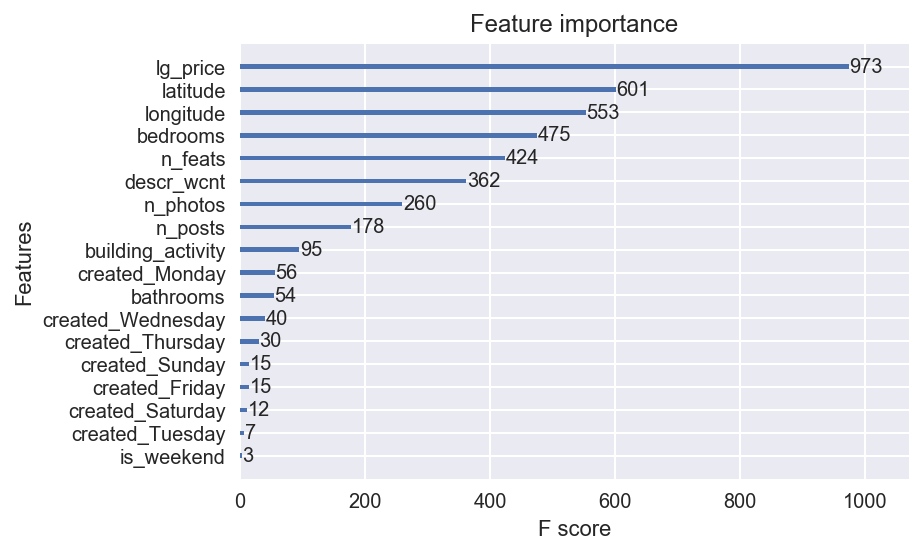

In [108]:
feat_imp = pd.Series(fscores, index=columns).sort_values(ascending=False)
xgb.plot_importance(clf.get_params()['xgb'].booster())

In [ ]:
parameters = dict(
    clf__max_depth=[3, 4, 5, 6],
)

clf = xgb.XGBClassifier(objective='multi:softprob', silent=1,
                        nthread=1, seed=SEED, missing=-999)



grid = GridSearchCV(clf, parameters, n_jobs=-1, scoring=scoring)
%timeit -r1 -n1 grid.fit(X_train, y_train)

print()
print(best_grid_results(grid))

Train score:    0.51588
Test score :    0.59350

37.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


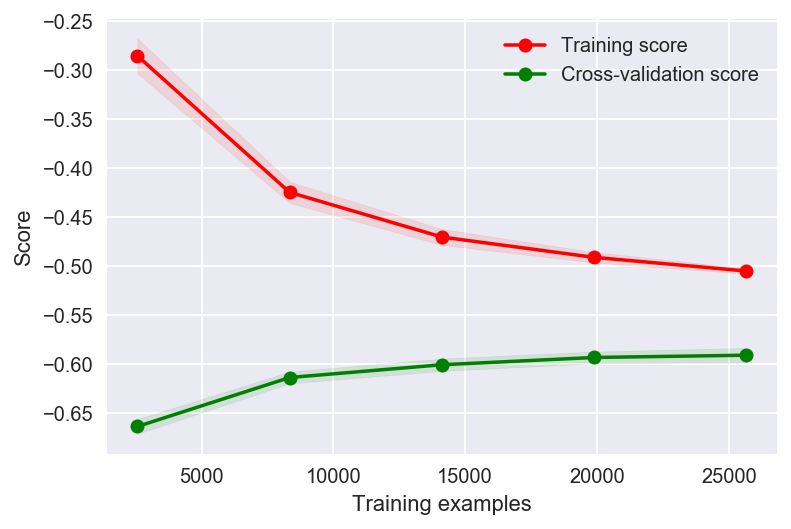

In [122]:
clf = grid.best_estimator_

y_pred = clf.predict_proba(X_train)
print('Train score: {:>10.5f}'.format(-log_loss(y_train, y_pred)))

y_pred = clf.predict_proba(X_test)
print('Test score : {:>10.5f}'.format(-log_loss(y_test, y_pred)))
print()

# cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=SEED)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    # so timeit works
    kwargs = dict(estimator=clf, X=X_train, y=y_train,
                  cv=cv, scoring=scoring, n_jobs=-1)
    %timeit -r1 -n1 plot_learning_curve(**kwargs)

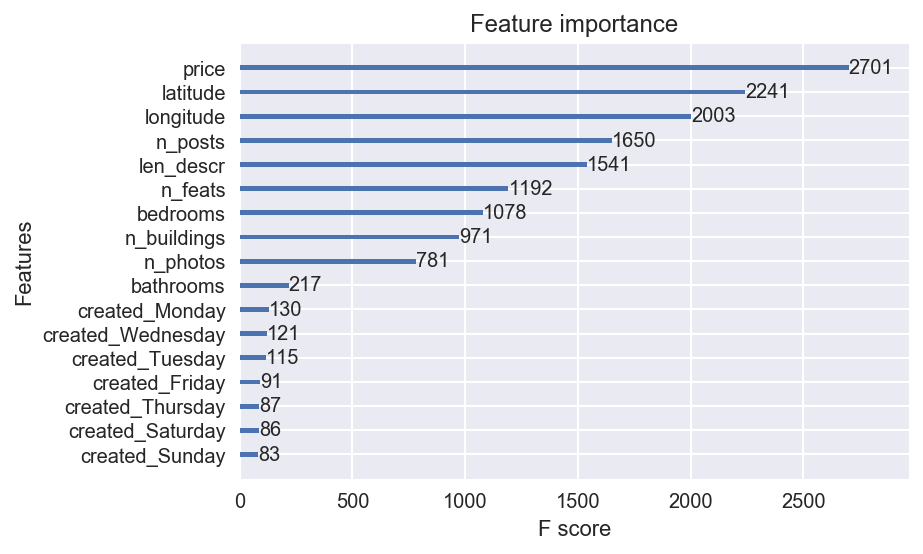

In [32]:
feat_imp = pd.Series(clf.booster().get_fscore()).sort_values(ascending=False)
xgb.plot_importance(clf.booster())

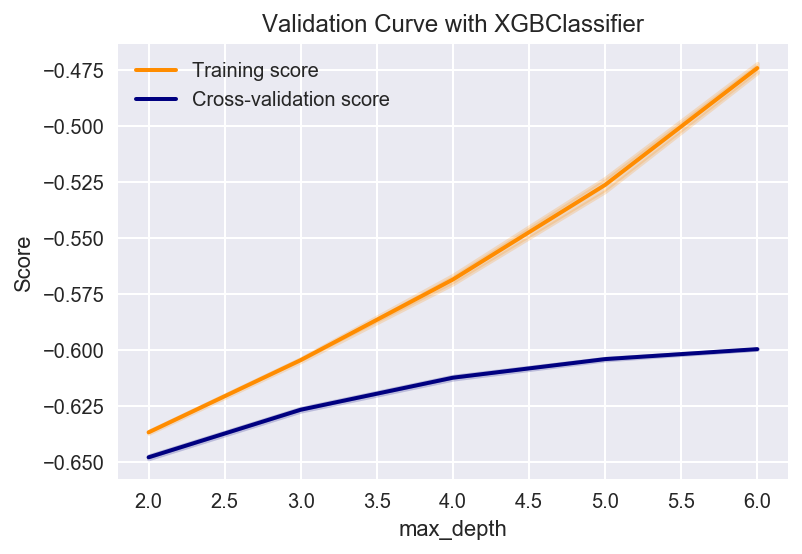

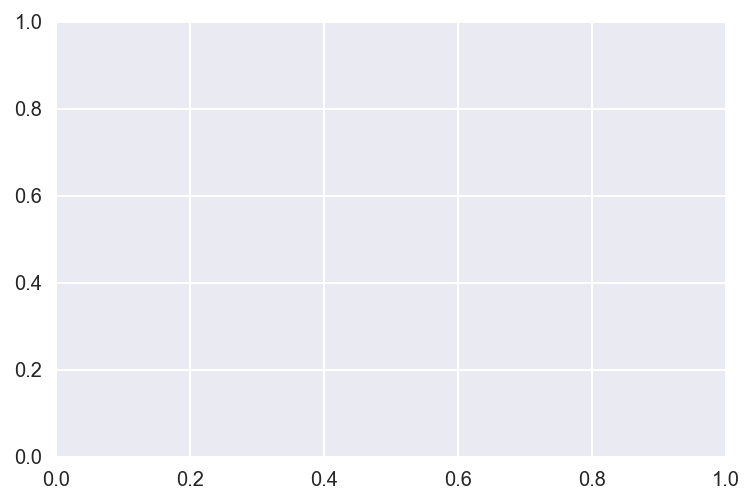

In [40]:
estimator = xgb.XGBClassifier(objective='multi:softprob', silent=0, seed=SEED)
estimator = clf
plot_validation_curve(estimator, X_train, y_train,
                      'max_depth', [2, 3, 4, 5, 6], cv=2, scoring=scoring,
                      n_jobs=-1)
plt.show()

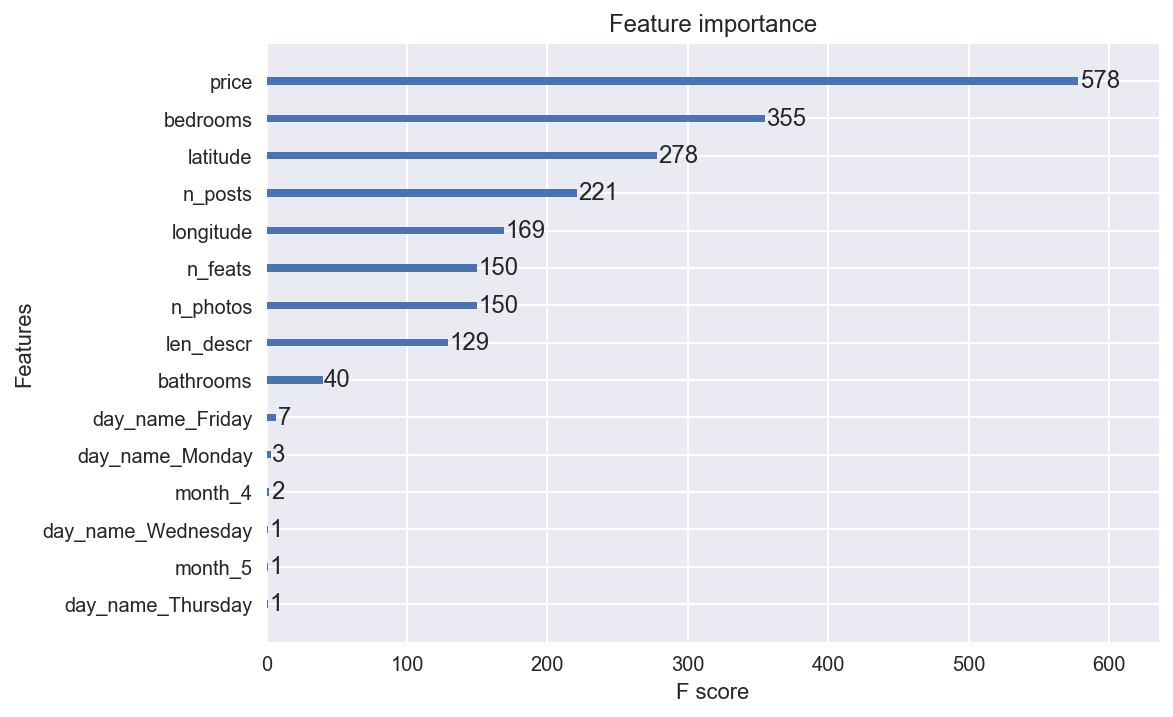

In [267]:
feat_imp = pd.Series(clf.booster().get_fscore()).sort_values(ascending=False)
xgb.plot_importance(clf.booster())

- Not easy to plot learning or vaidation curve because kernel needs to be restarted after `GridSearch` on `xgboost`. Need to use native cross-validation functions.

In [ ]:
# y_pred = clf.predict_proba(X_train)
# print('Train score: {:>10.5f}'.format(-log_loss(y_train, y_pred)))

# y_pred = clf.predict_proba(X_test)
# print('Test score : {:>10.5f}'.format(-log_loss(y_test, y_pred)))

# cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=SEED)
# with warnings.catch_warnings():
#     warnings.simplefilter('ignore')
#     plot_learning_curve(clf,
#                         X_train, y_train,
#                         cv=cv, scoring=scoring,
#                         n_jobs=-1)

In [ ]:
# clf = grid.best_estimator_
# clf = xgb.XGBClassifier(objective='multi:softprob', seed=SEED)

# param_name = 'max_depth'
# param_range = [2, 3, 4, 5, 6]

# cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=SEED)
# with warnings.catch_warnings():
#     warnings.simplefilter('ignore')
#     plot_validation_curve(clf, X_train, y_train, param_name, param_range,
#                           cv=cv, scoring=scoring, n_jobs=-1)

## `XGBoost`

In [17]:
import xgboost as xgb

/Users/mdlynch37/anaconda3/envs/py3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [27]:
dtrain = xgb.DMatrix(X_train, y_train, feature_names=X_train.columns)
dtest  = xgb.DMatrix(X_test, y_test, feature_names=X_test.columns)

evals  = [(dtest, 'eval'), (dtrain, 'train')]
evals_result = dict()

params = dict(
    max_depth=6,
    objective='multi:softmax',
    eval_metric='mlogloss',
    num_class=4,
    silent=0, 
)


bst = xgb.train(params, dtrain, num_boost_round=10, evals=evals,
                evals_result=evals_result
)

[0]	eval-mlogloss:1.13509	train-mlogloss:1.13017
[1]	eval-mlogloss:0.992171	train-mlogloss:0.982481
[2]	eval-mlogloss:0.898627	train-mlogloss:0.884873
[3]	eval-mlogloss:0.834232	train-mlogloss:0.816805
[4]	eval-mlogloss:0.790169	train-mlogloss:0.769531
[5]	eval-mlogloss:0.756866	train-mlogloss:0.73304
[6]	eval-mlogloss:0.73144	train-mlogloss:0.705025
[7]	eval-mlogloss:0.711759	train-mlogloss:0.683253
[8]	eval-mlogloss:0.696296	train-mlogloss:0.66434
[9]	eval-mlogloss:0.685253	train-mlogloss:0.650573


In [26]:
params = dict(
    max_depth=6,
    objective='multi:softmax',
    eval_metric='mlogloss',
    num_class=4,
    silent=0, 
)

xgb.cv(params, dtrain, num_boost_round=10, nfold=5, stratified=True,
       metrics=('mlogloss', 'merror'), seed=SEED)

,test-merror-mean,test-merror-std,test-mlogloss-mean,test-mlogloss-std,train-merror-mean,train-merror-std,train-mlogloss-mean,train-mlogloss-std
0,0.29470,0.00183,1.13554,0.00067,0.28275,0.00111,1.12910,0.00094
1,0.29174,0.00030,0.99237,0.00075,0.28042,0.00135,0.98156,0.00083
2,0.29044,0.00151,0.90003,0.00135,0.27874,0.00143,0.88457,0.00118
3,0.28971,0.00071,0.83550,0.00092,0.27734,0.00092,0.81573,0.00127
4,0.29016,0.00146,0.79071,0.00134,0.27597,0.00053,0.76732,0.00138
5,0.29024,0.00113,0.75767,0.00145,0.27521,0.00059,0.73106,0.00162
6,0.28935,0.00097,0.73248,0.00166,0.27332,0.00145,0.70279,0.00167
7,0.28903,0.00134,0.71292,0.00181,0.27123,0.00197,0.68013,0.00129
8,0.28850,0.00105,0.69822,0.00243,0.26934,0.00155,0.66209,0.00145
9,0.28724,0.00133,0.68604,0.00304,0.26707,0.00086,0.64665,0.00104


## Feature Engineering

In [ ]:
BASIC_FEATURES = ['bathrooms', 'bedrooms', 'price']
TARGET =  ['interest_level']


df = read_rental_interest(DF_TRAIN_PKL)
df_ = df[BASIC_FEATURES+TARGET]

X = df.drop('interest_level', axis=1)

X_train, X_test, y_train, y_test = (
    train_test_split(
        X, y, test_size=.2, stratify=y)
    )

X_train.shape

In [ ]:
np.bincount(y)

### Feature lists

#### Explore

In [ ]:
n_feats = df.features.map(lambda x: len(x))
plt.hist(n_feats, cumulative=True, normed=True, bins=300, align='left')
plt.title('CDF of number of features for each listing.')
print('min: {} (n={})\nmed: {}\nmax: {}'.format(
    n_feats.min(), (n_feats==0).sum(),
    n_feats.median(), n_feats.max()))
# n_feats.value_counts(normalize=True).sort_index()

In [ ]:
def contains_punc(criteria, feats_list, regex=False):
    """Checks for punctuation in feature list.
    
    Can be used to determine the nature of difference
    puncuations.
    
    Parameters
    ----------
    criteria : list of str or raw/str
        list of punctuation marks, or regex to match punctuation
    feats_list : list
    
    Returns
    -------
    has_punc : bool
    """
    
    if regex:
        reg = re.compile(criteria)
    
    # return True 
    for feat in feats_list:
        if regex:
            if reg.match(feat):
                return True
        else:
            for s in criteria:
                if s in feat:
                    return True
    
    # if no punctuation found in list of features
    return False

In [ ]:
from collections import Counter
import re

def extract_clean_feats(feats):
    """Extract and normalize each feature in list."""
    
#     cleaner = lambda x: re.sub(r'[ ]*[^\w ][ ]*', ' ', x)
    cleaner = lambda x: x.upper().strip().replace('-', '')
#     cleaner = lambda x: x
    cleaned = (cleaner(feat) for feat in feats)
    
    return cleaned


def count_feats(feat_col):
    """Extracts features from list and returns counter."""
    
    cnt = Counter()
    for _, feats in feat_col.iteritems():
        feats = set(extract_clean_feats(feats))  # remove dupes too
        cnt.update(feats)
        
    return cnt

feat_cnts = count_feats(df.features)
feat_cnts.most_common(5)

In [ ]:
df[df.features.map(lambda x: contains_punc(['*'], x))].head(2)

#### Include feature lists in model

In [ ]:
def binarize_from_list_vals(col):
    """Transforms Series of lists to dummy variables."""
    
    SEP = '~~//'  # any value that won't be in strings in list

    cleaned = col.apply(lambda x: extract_clean_feats(x))
    dummies = cleaned.str.join(sep=SEP).str.get_dummies(sep=SEP)

    return dummies


In [ ]:
# Testing against feature counter
# Discrepency caused by duplicate feats within a list
# Fix this with set() call in count_feats

if 1==0:
    feats_df = binarize_from_list_vals(df.features)

    results = []

    for i, (feat, cnt) in enumerate(feat_cnts.items()):
        try:
            cnt_dumm = feats_df[feat].sum()
            if cnt != cnt_dumm:
    #             print("Mismatch...\ndummies: {}\ncounter: {}\n'{}'\n"
    #                   .format(cnt_dumm, cnt, feat))
                results.append(dict(feat=feat, cnt_dumm=cnt_dumm, cnt=cnt))   
        except KeyError:
            results.append("Missing from dummies:\n'{}'\n".format(feat))
    #         break  # since it is not included in results list of dicts

    assert not results  # no discrepencies!

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()

feats_train = feats_df.loc[X_train.index]
feats_test = feats_df.loc[X_test.index]

pca.fit(feats_train)

In [ ]:
list(pca.explained_variance_ratio_[:4])

In [ ]:
plt.title('Cumulative Explained Variance for PCA')

plt.plot(np.cumsum(pca.explained_variance_ratio_))

plt.xlim(0, 150)
plt.xlabel('components')
plt.ylabel('cumulative explained variance');

In [ ]:
N_COMPONENTS = 1000
# N_COMPONENTS = len(pca.components_)

cols = ['FeatComp{}'.format(i+1) for i in range(0, N_COMPONENTS)]

reduced_train = pd.DataFrame(
    pca.transform(feats_train)[:, :N_COMPONENTS], 
    columns=cols, index=feats_train.index
)
reduced_test  = pd.DataFrame(
    pca.transform(feats_test)[:, :N_COMPONENTS], 
    columns=cols, index=feats_test.index
)

# allows rejoining reduced data after reprocessing
X_train = X_train.loc[:, ~X_train.columns.isin(cols)]
X_test  = X_test.loc[:, ~X_test.columns.isin(cols)]

X_train = X_train.join(reduced_train)
X_test  = X_test.join(reduced_test)

In [ ]:
N = len(feats_train)

In [ ]:
steps = [('reducer', PCA()),
         ('clf', GradientBoostingClassifier(min_samples_split=50))]
pipe = Pipeline(steps=steps)

params = {
    'reducer': [PCA(), TruncatedSVD()],
    'reducer__n_components': [200, 300, 400],
#     'clf__min_samples_split': [120],
#     'clf__learning_rate': np.linspace(0.1, 0.4, 5),
#     'clf__learning_rate': [0.05, 0.1, 0.15],
#     'clf_max_depth': range(3, 7, 1),
#     'pca__n_components': [10, 20, 25],
#     'pca__n_components': [10, 40],
#     'clf__min_samples_split': [120, 180],
              }

grid = GridSearchCV(pipe, params, scoring=scoring, n_jobs=-1)
grid.fit(feats_train.iloc[:N], y_train[:N])
grid.best_score_

In [ ]:
gx = GridSearchExplorer(grid)
gx.plot(x='reducer__n_components', hue='reducer')

#### Combine with BASIC

In [ ]:
from sklearn.base import TransformerMixin

class DateEncoder(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        dt = X.dt
        return pd.concat([dt.year, dt.month, dt.day], axis=1)
dates_df = pd.DataFrame(
    {'dates': pd.date_range('2015-10-30', '2015-11-02')})
mapper_dates = DataFrameMapper([
    ('dates', DateEncoder())
], input_df=True)
mapper_dates.fit_transform(dates_df)


In [ ]:
from sklearn_pandas import DataFrameMapper

class LogTransformer(TransformerMixin):
    
    def fit(self, X):
        return self
    
    def transform(self, X):
        return np.log(X)
    
dm = DataFrameMapper([
    (['bedrooms', 'bathrooms'], MinMaxScaler()),
    (['price'], [LogTransformer(), MinMaxScaler()])
])

dm.fit_transform(df)

In [ ]:
FEATURES = ['bathrooms', 'bedrooms', 'price', 'features']
TARGET =  ['interest_level']


df = read_rental_interest(TRAIN_FP, frac=.)
df_ = df[FEATURES+TARGET]


feats_bow = binarize_from_list_vals(df.features)

In [ ]:
X = df.drop(['interest_level', 'features'], axis=1).values
X = np.hstack((X, feats_bow))

X_train, X_test, y_train, y_test = (
    train_test_split(
        X, y, test_size=.2, stratify=y)
    )


X_train.shape

In [ ]:
from sklearn.svm import SVC


class FeatureSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, slice_):
        self.slice_ = slice_

    def fit(self, x, y=None):
        return self

    def transform(self, x, y=None):
        return x[:, self.slice_]


pipe = Pipeline([
    ('union', FeatureUnion([
        ('feature_list', Pipeline([
            ('selector', FeatureSelector(slice(3, None))),
            ('reducer', TruncatedSVD(n_components=100))
        ])),
        ('selector', FeatureSelector(slice(None, 3)))
    ])
    ),
    ('clf', GradientBoostingClassifier())
])

pipe.fit(X_train, y_train)

param_grid = {
#     'union__feature_list__reducer': [TruncatedSVD(), PCA()],
#     'union__feature_list__reducer__n_components': [100, 200],
    'clf__n_estimators': [100, 200, 500],
    'clf__min_samples_split': [2, 10, 50],
    'clf__learning_rate':[0.05, 0.1, .15]
#       'clf': [GradientBoostingClassifier(), SVC(probability=True),
#               RandomForestClassifier()]
}

grid = GridSearchCV(pipe, param_grid, scoring=scoring, n_jobs=-1)
grid.fit(X_train, y_train)
grid.best_score_

In [ ]:
grid.best_params_

In [ ]:
GridSearchExplorer(grid).plot(x='clf__n_estimators',
                              hue='clf__min_samples_split')

In [ ]:
from sklearn.svm import SVC


class FeatureSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, slice_):
        self.slice_ = slice_

    def fit(self, x, y=None):
        return self

    def transform(self, x, y=None):
        return x[:, self.slice_]


pipe = Pipeline([
    ('union', FeatureUnion([
        ('feature_list', Pipeline([
            ('selector', FeatureSelector(slice(3, None))),
            ('reducer', TruncatedSVD(n_components=100))
        ])),
        ('selector', FeatureSelector(slice(None, 3)))
    ])
    ),
    ('clf', GradientBoostingClassifier())
])

pipe.fit(X_train, y_train)

param_grid = {
#     'union__feature_list__reducer': [TruncatedSVD(), PCA()],
#     'union__feature_list__reducer__n_components': [100, 200],
    'clf__n_estimators': [100, 200, 500],
    'clf__min_samples_split': [2, 10, 50],
    'clf__learning_rate':[0.05, 0.1, .15]
#       'clf': [GradientBoostingClassifier(), SVC(probability=True),
#               RandomForestClassifier()]
}

grid = GridSearchCV(pipe, param_grid, scoring=scoring, n_jobs=-1)
grid.fit(X_train, y_train)
grid.best_score_

In [ ]:
gx = GridSearchExplorer(grid)
gx.plot(x='clf__learning_rate', hue='clf__n_estimators')

In [ ]:
# confusion matrix

### NLP with description feature:

In [ ]:
words = Counter()

def extract_words(feats):
    feats = [re.sub(r'[ ]*[^\w ][ ]*', ' ', s.upper())
             for s in feats]
    words = [word for s in feats for word in s.split()]
    
    return words

In [ ]:
for idx, feats in df.features.iteritems():
    words.update(extract_words(feats))

In [ ]:
words.most_common()

In [ ]:
df = read_rental_interest(DF_TRAIN_PKL)

In [ ]:
with open(TRAIN_FP) as f:
    x = f.read()
a = 10011000
x[a:a+540]

In [ ]:
s = 'itness gym, laundry facility & pet-friendly'

df[df.description.str.contains(s)].iat[0, 4]

- Strip:
    - leading spaces
    - html tags: `<br /><br />`
    - html entities?
    - returns: `\r`
    - weird separators
- Replace:
    - `w/ ` to `with`
    - `washer /dryer` and other unspaced slashes
    - `&` to `and`
- Separate words joined between sentences
    - e.g. `FloorsLimed Brick WallsPrivate BalconiesIntricate`
    - very important, lots of instances, spearate by caps
    - not possible when all caps
- Separate joined word without caps:
    - `Long Island Railroad isabout a 10 `

- New features:
    - Length of description
    - Has website (`website_redacted` or html tag)
    - Has email
    - Has phone number


In [ ]:
df.description.values[]
raise

In [ ]:
nlp = spacy.load('en')

### Other features

## Misc

### Train vs Test

In [128]:
df_test = read_rental_interest(DF_TEST_PKL)
df_train = read_rental_interest(DF_TRAIN_PKL).drop('interest_level', axis=1)

In [129]:
quant = df_train.select_dtypes([int, float]).columns.tolist()
qual = [col for col in df_train.columns if col in quant]

Quantitative

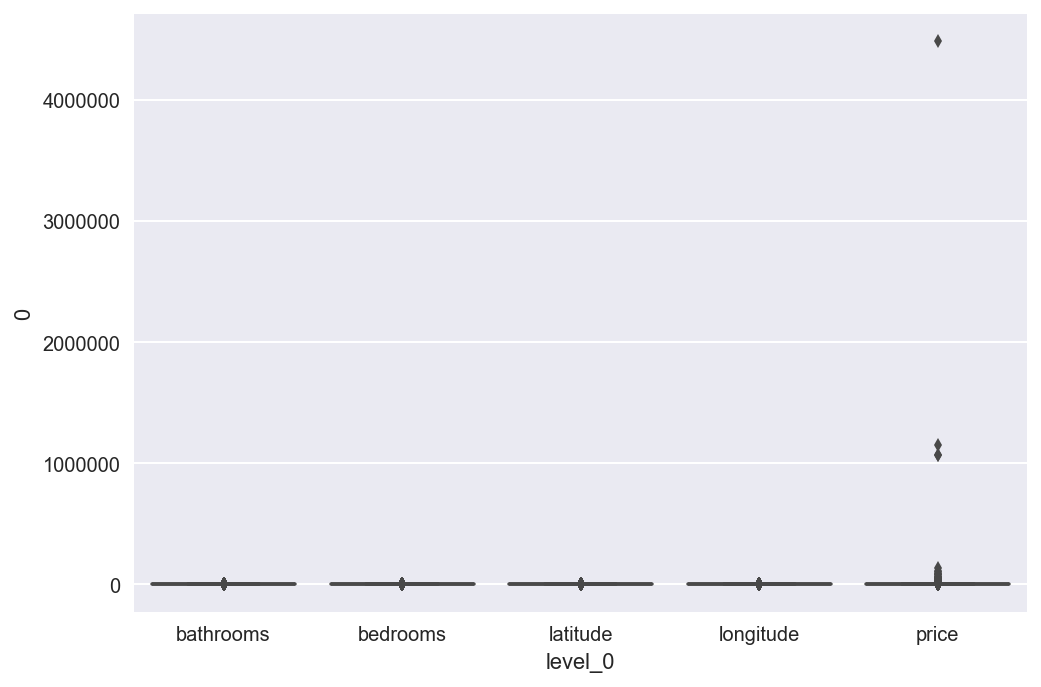

In [130]:
sns.boxplot(x='level_0', y='0', data=df_train[quant].unstack().rename('0').reset_index(level=0))

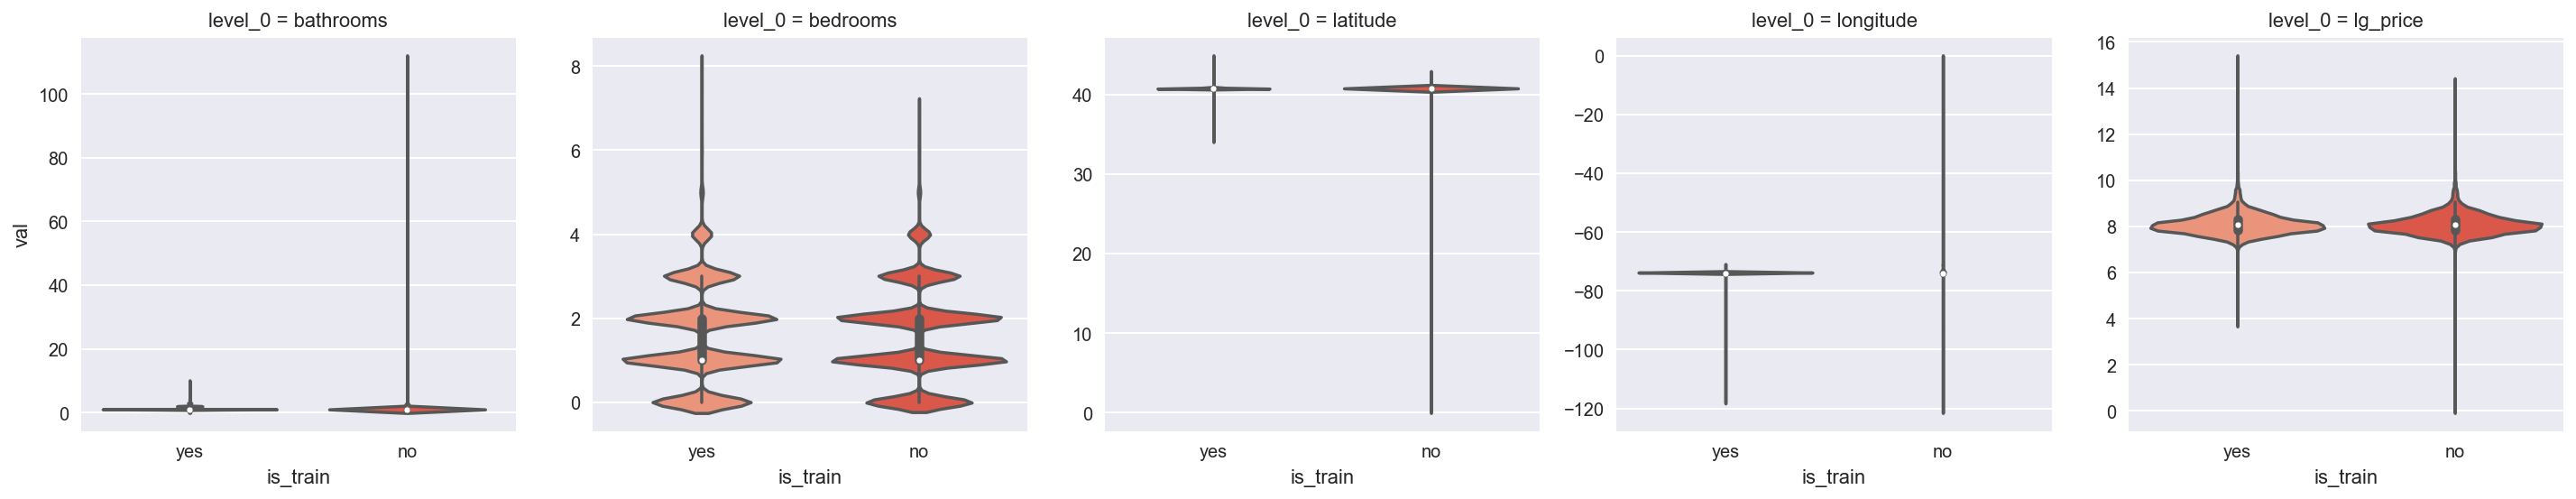

In [183]:
def basic_outl_drop(df):
    df = df.copy()
#     %%debug
#     import pdb; pdb.set_trace()
    df = df.loc[df.latitude!=0]
    df = df.loc[df.longitude!=0]
    df.price = np.log(df.price)
    df = df.rename(columns=dict(price='lg_price'))
    return df
    

data_tr_st = (df_train[quant].pipe(basic_outl_drop)
              .unstack()
              .rename('val')
              .reset_index(level=0)
)
data_te_st = (df_test[quant].pipe(basic_outl_drop)
              .unstack()
              .rename('val')
              .reset_index(level=0)
)
data = pd.concat([
    data_tr_st.assign(is_train='yes'),
    data_te_st.assign(is_train='no')
])
sns.factorplot(col='level_0', y='val', data=data, hue_order=['yes', 'no'],
               kind='violin', sharey=False, split=True, x='is_train')

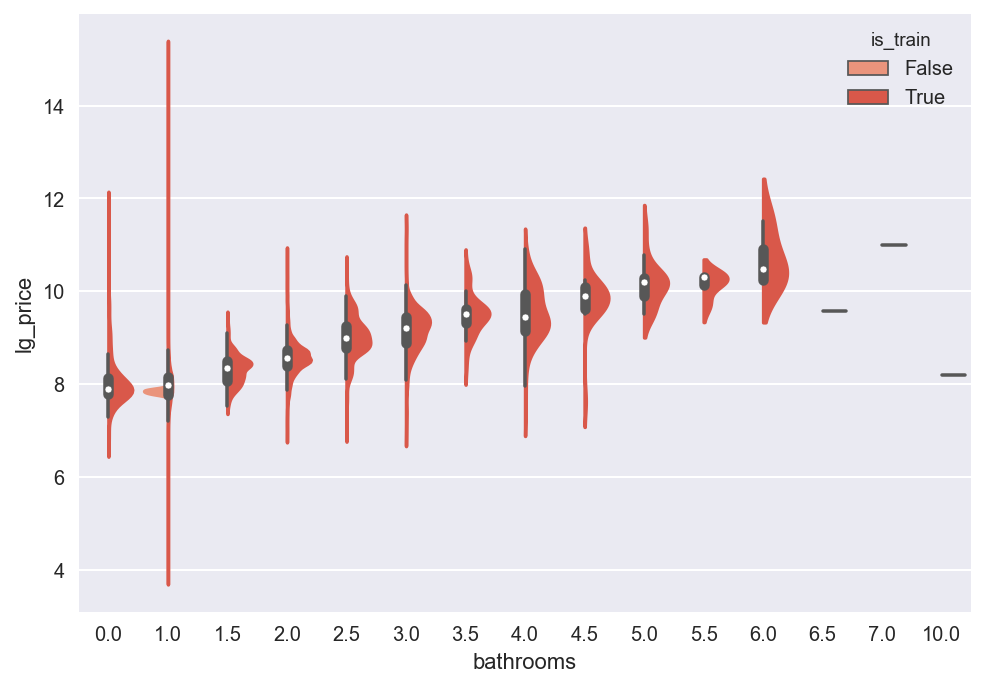

In [181]:
sns.violinplot(y='lg_price', 
               x='bathrooms',
               data=df_train.assign(is_train=df_train.latitude>40).pipe(basic_outl_drop),
               hue='is_train',
               split=True)

In [ ]:
def are_duplicated(df, normed=True):
    dupe_ns = []
    dupes = {}
    for name, ser in df.iteritems():
        print(name)
        print(type(ser))
        n = ser[ser.duplicated(keep=False)].sum()
        if type(n) is not int:
            %debug
        if normed:
            if type(n) is not int:
                print(n)
            n /= len(df)
        dupe_ns.append(n)
        dupes[name] = n
    
    return pd.DataFrame(dupes).T

are_duplicated(df)